In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import matplotlib as mpl

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneGroupOut, StratifiedGroupKFold, GroupKFold
import numpy as np
import re

In [4]:
df_wts_all_mean = pd.read_csv('../data/training/cper_28day_weights_2000_2024_cln_mean.csv',
                              parse_dates=['on_date', 'off_date'])
df_wts_all_mean['period'] = df_wts_all_mean['period'].astype(str)

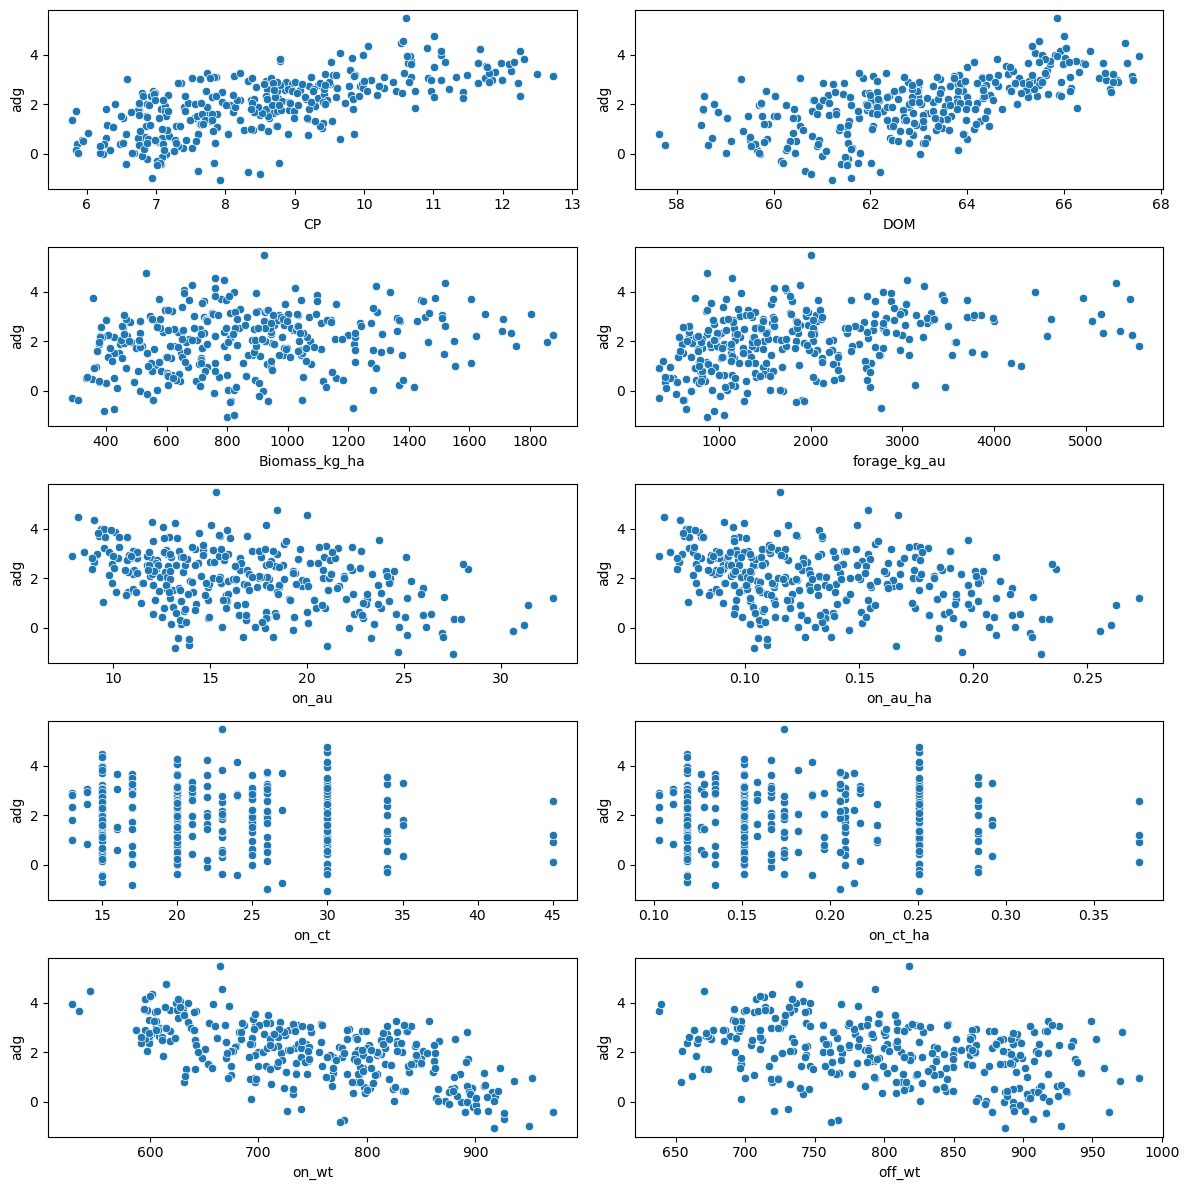

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(12,12))
sns.scatterplot(x='CP', y='adg', data=df_wts_all_mean, ax=axs[0,0])
sns.scatterplot(x='DOM', y='adg', data=df_wts_all_mean, ax=axs[0,1])
sns.scatterplot(x='Biomass_kg_ha', y='adg', data=df_wts_all_mean, ax=axs[1,0])
sns.scatterplot(x='Biomass_kg_ha', y='adg', data=df_wts_all_mean[df_wts_all_mean['period'] == 2], ax=axs[1,0])
sns.scatterplot(x='forage_kg_au', y='adg', data=df_wts_all_mean, ax=axs[1,1])
sns.scatterplot(x='on_au', y='adg', data=df_wts_all_mean, ax=axs[2,0])
sns.scatterplot(x='on_au_ha', y='adg', data=df_wts_all_mean, ax=axs[2,1])
sns.scatterplot(x='on_ct', y='adg', data=df_wts_all_mean, ax=axs[3,0])
sns.scatterplot(x='on_ct_ha', y='adg', data=df_wts_all_mean, ax=axs[3,1])
sns.scatterplot(x='on_wt', y='adg', data=df_wts_all_mean, ax=axs[4,0])
sns.scatterplot(x='off_wt', y='adg', data=df_wts_all_mean, ax=axs[4,1])
fig.tight_layout()

<Axes: xlabel='on_wt', ylabel='adg'>

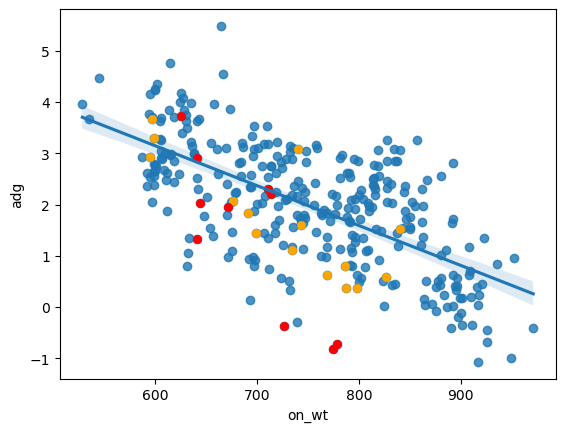

In [6]:
df_wts_all_mean['Year_str'] = df_wts_all_mean['Year'].astype(str)
x_var='on_wt'
p = sns.regplot(x=x_var, y='adg', data=df_wts_all_mean, scatter_kws=dict(ec=None))
sns.scatterplot(x=x_var, y='adg', data=df_wts_all_mean[df_wts_all_mean['Year'].isin([2018])], ax=p, c='orange', ec=None)
sns.scatterplot(x=x_var, y='adg', data=df_wts_all_mean[df_wts_all_mean['Year'].isin([2022])], ax=p, c='red', ec=None)

In [7]:
features_in = ['CP', 'DOM', 'Biomass_kg_ha', 'on_ct', 'on_wt']
#features_in = ['CP', 'DOM', 'forage_kg_au', 'on_ct', 'on_wt']

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAE': 'neg_mean_absolute_error'}
param_grid = {
    #'RF__min_samples_leaf': [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.10],
    'RF__n_estimators': [10, 20, 30, 50, 100],
    'RF__max_samples': [0.05, 0.10, 0.25, 0.5, 0.75],
    'RF__max_features': [1, 2, 3, 4, 5],
    #'RF__ccp_alpha': [0.01, 0.025, 0.05, 0.10]
}

logo_group = 'Year'
nsplits = 6

logo = LeaveOneGroupOut()
skf = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=321)
sgkf = StratifiedGroupKFold(n_splits=nsplits, shuffle=True, random_state=321)
gkf = GroupKFold(n_splits=nsplits)

In [8]:
# Create a based model
rf_pipe = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_jobs=4))
                ])

In [9]:
df_wts_all_mean['Year'] = df_wts_all_mean['Year'].astype(str)
df_wts_all_mean['period'] = df_wts_all_mean['period'].astype(str)

In [10]:

# Instantiate the grid search model
#logo_cv = logo.split(df_wts_all_mean[features_in], 
#                   df_wts_all_mean['adg'],
#                   df_wts_all_mean['Year'])
logo_cv = logo.split(df_wts_all_mean[features_in], 
                   df_wts_all_mean['adg'],
                   df_wts_all_mean[logo_group])

skf_cv = skf.split(df_wts_all_mean[features_in], 
                   df_wts_all_mean['period'])

sgkf_cv = sgkf.split(df_wts_all_mean[features_in], 
                   df_wts_all_mean['period'],
                    df_wts_all_mean['Year'])

gkf_cv = gkf.split(df_wts_all_mean[features_in], 
                   df_wts_all_mean['adg'],
                   df_wts_all_mean[logo_group])

In [11]:
adg_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='MAE', return_train_score=True,
                               cv=sgkf_cv, n_jobs=-1, verbose=0)
# Fit the grid search to the data
adg_grid_search.fit(df_wts_all_mean[features_in], 
                    df_wts_all_mean['adg'])
adg_results = adg_grid_search.cv_results_

In [12]:
print('----Test Results----')
print('R^2-CV: ' + str(adg_results['mean_test_R2'][adg_results['rank_test_MAE'] == 1]))
print('R^2-CV std: ' + str(adg_results['std_test_R2'][adg_results['rank_test_MAE'] == 1]))
print('MAE-CV: ' + str(-1.0 * adg_results['mean_test_MAE'][adg_results['rank_test_MAE'] == 1]))
print('MAE-CV std: ' + str(adg_results['std_test_MAE'][adg_results['rank_test_MAE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[adg_results['rank_test_MAE'] == 1] for
             key, value in adg_results.items() if re.search('split+\d_test_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[adg_results['rank_test_MAE'] == 1] for
             key, value in adg_results.items() if re.search('split+\d_test_MSE', key)]))))

----Test Results----
R^2-CV: [0.53396599]
R^2-CV std: [0.02385585]
MAE-CV: [0.61932766]
MAE-CV std: [0.03899339]
RMSE-CV: 0.7965520307312041
RMSE-CV std: 0.06039765948407126


In [13]:
print('----Train Results----')
print('R^2-CV: ' + str(adg_results['mean_train_R2'][adg_results['rank_test_MAE'] == 1]))
print('R^2-CV std: ' + str(adg_results['std_train_R2'][adg_results['rank_test_MAE'] == 1]))
print('MSE-CV: ' + str(-1.0 * adg_results['mean_train_MAE'][adg_results['rank_test_MAE'] == 1]))
print('MSE-CV std: ' + str(adg_results['std_train_MAE'][adg_results['rank_test_MAE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[adg_results['rank_test_MAE'] == 1] for
             key, value in adg_results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[adg_results['rank_test_MAE'] == 1] for
             key, value in adg_results.items() if re.search('split+\d_train_MSE', key)]))))

----Train Results----
R^2-CV: [0.88127677]
R^2-CV std: [0.00631351]
MSE-CV: [0.30360271]
MSE-CV std: [0.01111075]
RMSE-CV: 0.40526398110598055
RMSE-CV std: 0.015857725745513158


In [14]:
df_results_adg = pd.DataFrame({k:adg_results[k] for k in adg_results.keys() if not k.startswith('split')})
#df_results_adg.loc[df_results_adg['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
#df_results_adg['param_RF__max_samples'] = df_results_adg['param_RF__max_samples'].astype(str)

In [15]:
#if use_logo:
#    nsplits = len(df_wts_all_mean[logo_group].unique())

res_df = pd.DataFrame()
for c in ['split'+str(i)+'_test_R2' for i in range(nsplits)]:
    res_df[c] = adg_results[c]
df_results_adg['median_test_R2'] = res_df.median(axis=1)

res_df = pd.DataFrame()
for c in ['split'+str(i)+'_train_R2' for i in range(nsplits)]:
    res_df[c] = adg_results[c]
df_results_adg['median_train_R2'] = res_df.median(axis=1)

In [16]:
#df_results_adg

In [17]:
for idx, c in enumerate(['split'+str(i)+'_test_R2' for i in range(nsplits)]):
    print(df_wts_all_mean[logo_group].unique()[idx], adg_results[c][adg_results['rank_test_MAE'] == 1])

2000 [0.53998653]
2001 [0.54017441]
2002 [0.55148704]
2003 [0.56513405]
2004 [0.51365282]
2005 [0.49336109]


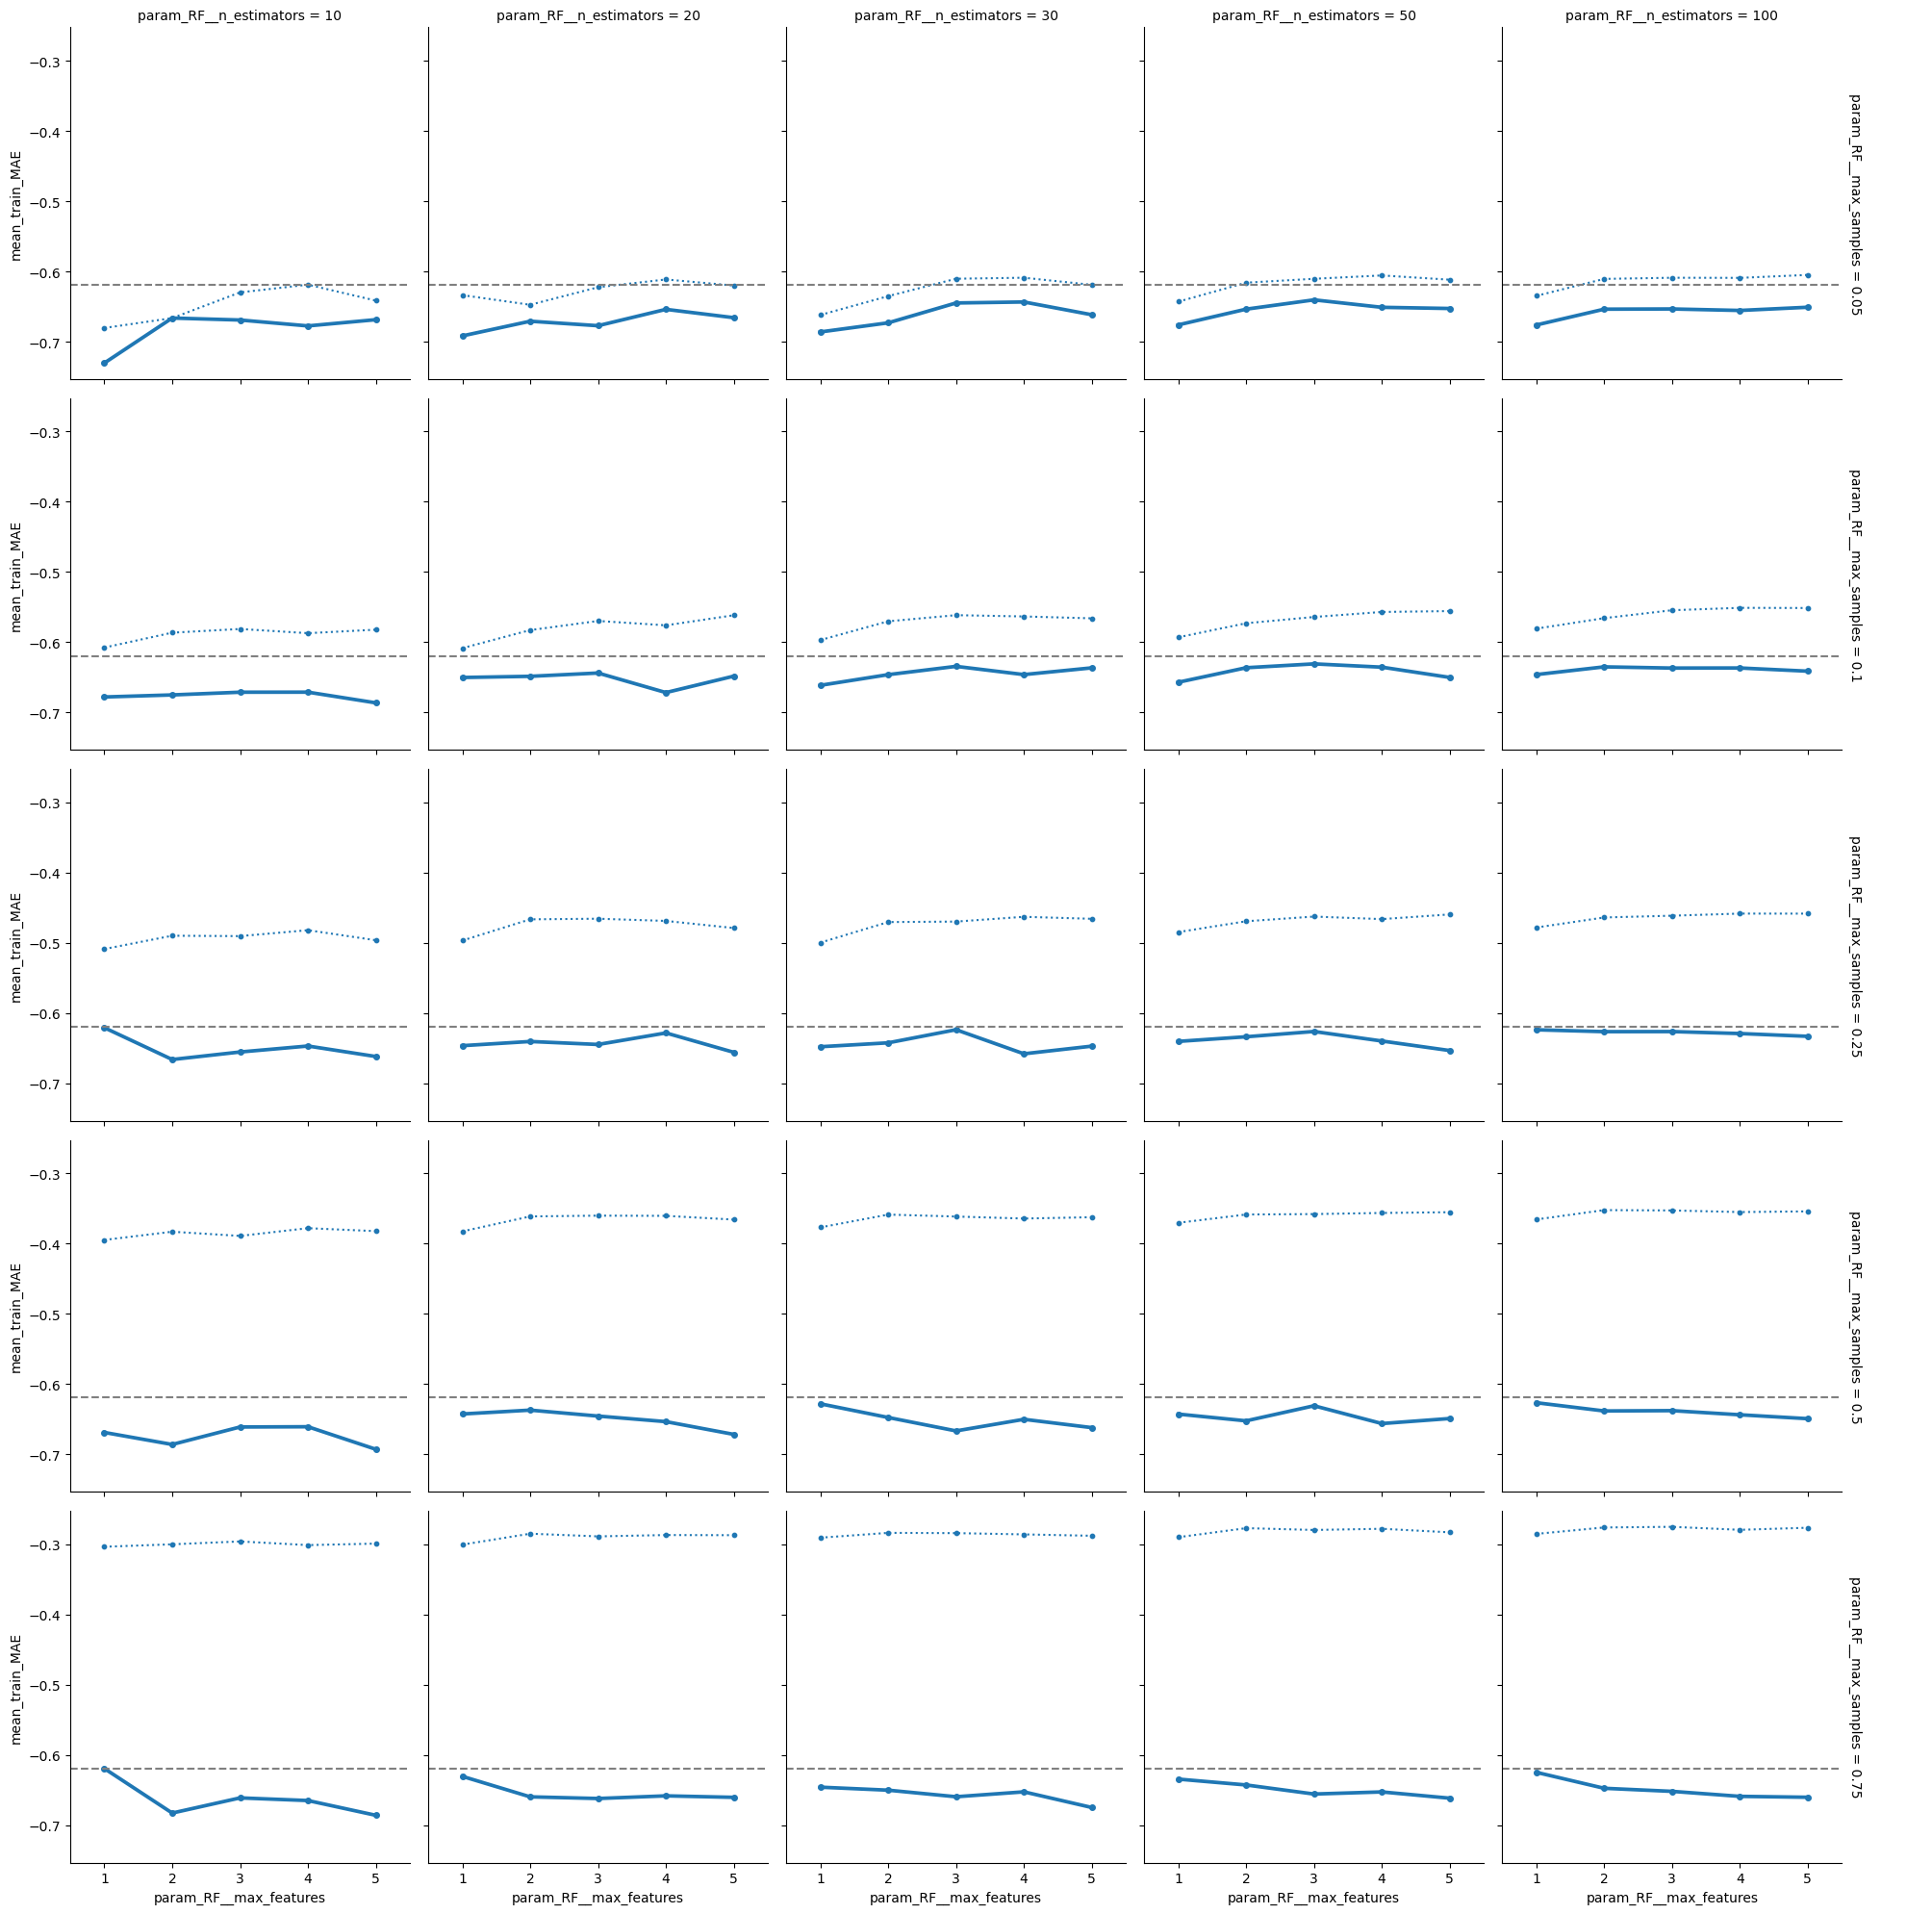

In [18]:
p = sns.FacetGrid(data=df_results_adg,
                  row='param_RF__max_samples', 
                  #hue='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=1, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MAE', markersize=3, dodge=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MAE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((-1.5, -0.1))
    ax.axhline(y=df_results_adg['mean_test_MAE'].max(), color='grey', linestyle='dashed')
p.add_legend()

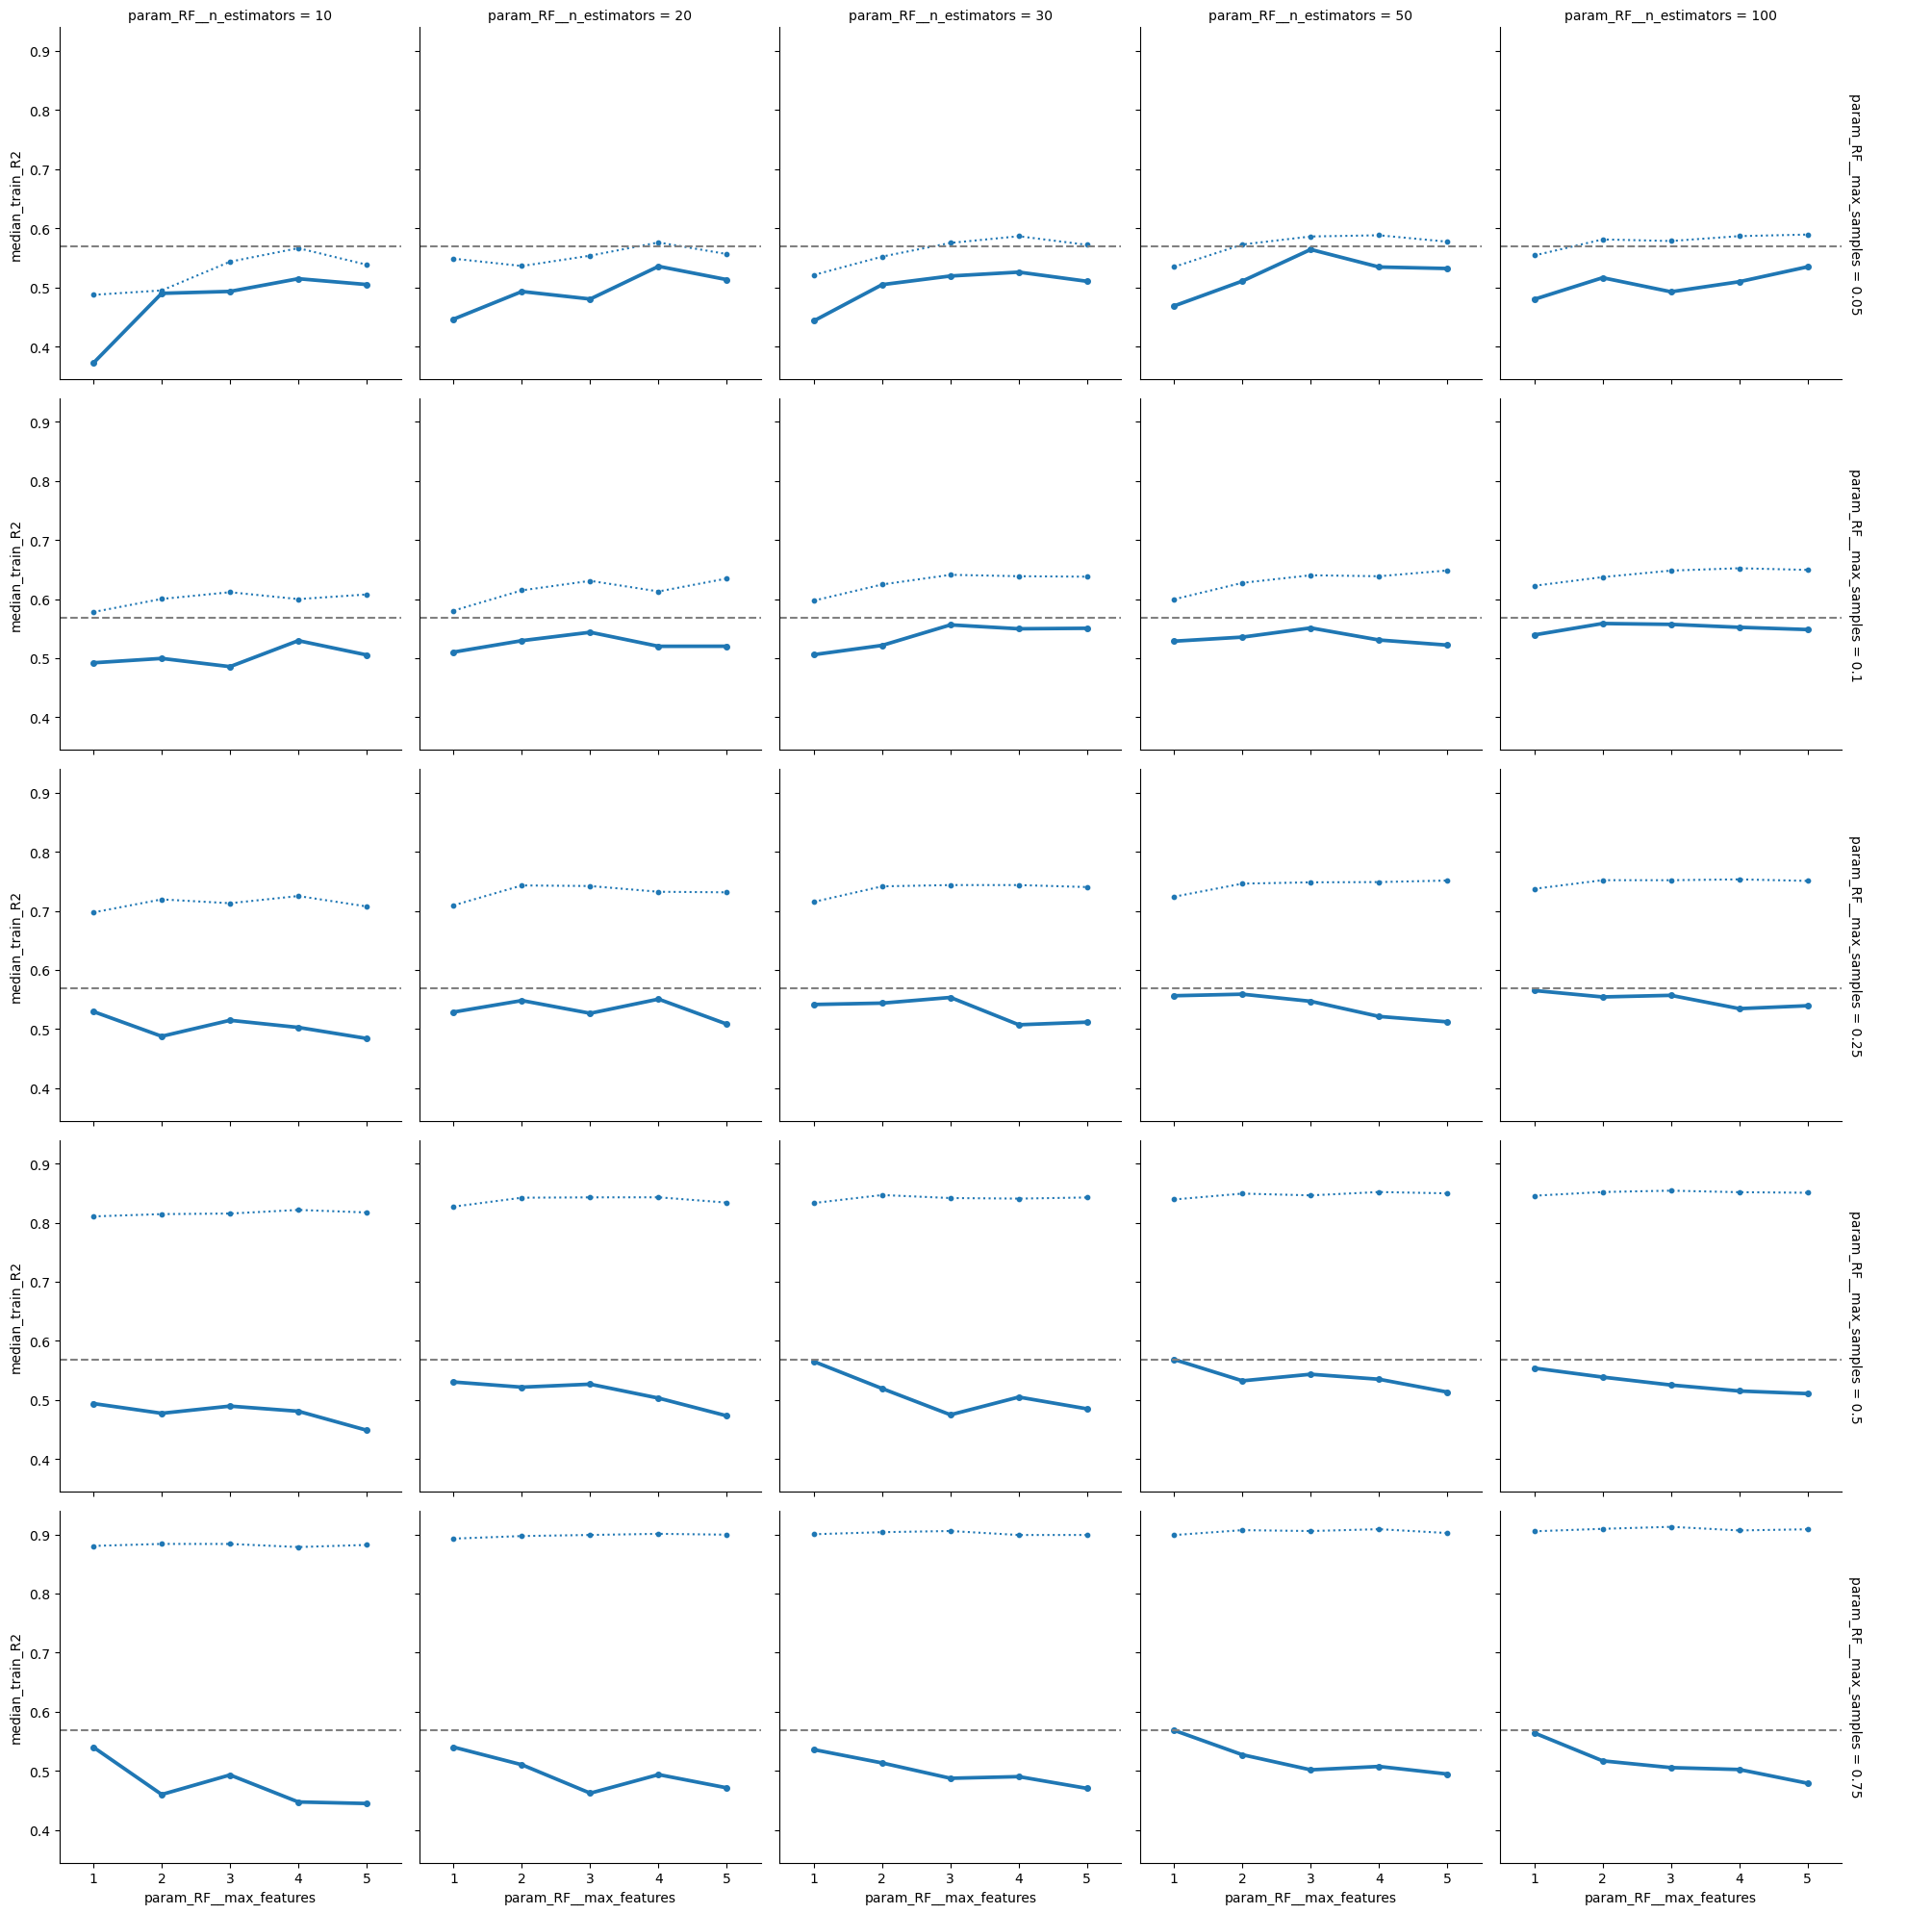

In [19]:
p = sns.FacetGrid(data=df_results_adg,
                  row='param_RF__max_samples', 
                  #hue='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=1, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='median_test_R2', markersize=3)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='median_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((0.5, 1.0))
    ax.axhline(y=df_results_adg['median_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [20]:
adg_grid_search.best_params_

{'RF__max_features': 1, 'RF__max_samples': 0.75, 'RF__n_estimators': 10}

In [67]:
use_best = False
if use_best:
    rf_adg_fnl = rf_pipe.set_params(**adg_grid_search.best_params_)
else:
    # for logo
    #rf_adg_fnl = rf_pipe.set_params(**{'RF__max_features': 1,
    #                                 'RF__max_samples': 0.25,
    #                                 'RF__min_samples_leaf': 0.025,
    #                                 'RF__n_estimators': 50})

    # for logo - currently saved
    #rf_adg_fnl = rf_pipe.set_params(**{'RF__max_features': 1,
    #                                 'RF__max_samples': 0.1,
    #                                 'RF__min_samples_leaf': 0.001,
    #                                 'RF__n_estimators': 250})

    # for logo2 
    rf_adg_fnl = rf_pipe.set_params(**{'RF__max_features': 1,
                                     'RF__max_samples': 0.25,
                                     #'RF__min_samples_leaf': 0.01,
                                     'RF__n_estimators': 100})
    
    
    # for skf
    #rf_adg_fnl = rf_pipe.set_params(**{'RF__max_features': 2,
    #                                 'RF__max_samples': 0.25,
    #                                 'RF__min_samples_leaf': 0.001,
    #                                 'RF__n_estimators': 250})
    # for skf with year
    #rf_adg_fnl = rf_pipe.set_params(**{'RF__max_features': 2,
    #                                 'RF__max_samples': 0.25,
    #                                 'RF__min_samples_leaf': 0.001,
     #                                'RF__n_estimators': 50})

In [68]:
np.random.seed(321)
rf_adg_fnl.fit(df_wts_all_mean[features_in], 
                    df_wts_all_mean['adg'],)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.25,
                                       n_jobs=4))])

In [69]:
rf_adg_fnl.score(df_wts_all_mean[features_in], 
                    df_wts_all_mean['adg'])

0.7384918203600377

In [70]:
from statsmodels.formula.api import ols

In [71]:
import numpy as np
def poly(x, degree):
    return np.vander(x, degree + 1, increasing=True)[:, 1:]

In [72]:
#mod = ols(formula="adg ~ poly(CP, 2) + poly(DOM, 2) + poly(Biomass_kg_ha, 2) + on_au:DOM + on_au:CP + on_au:poly(Biomass_kg_ha, 2)" +
#          "+ CP:DOM + CP:poly(Biomass_kg_ha, 2) + DOM:poly(Biomass_kg_ha, 2)", 
#          data=df_wts_all_mean)
#mod = ols(formula="adg ~ CP * DOM * np.log(Biomass_kg_ha) * on_wt + on_ct:CP + on_ct:DOM + on_ct:np.log(Biomass_kg_ha)", 
#          data=df_wts_all_mean)

mod = ols(formula="adg ~ np.sqrt(CP) * poly(DOM, 2) * np.log(Biomass_kg_ha)" +
          "+ on_wt:np.sqrt(CP) + on_wt:DOM + on_wt:np.log(Biomass_kg_ha)" +
          "+ on_ct:np.sqrt(CP) + on_ct:DOM + on_ct:np.log(Biomass_kg_ha)" +
          "+ on_ct", 
          data=df_wts_all_mean)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    adg   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     25.86
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           4.55e-51
Time:                        11:35:28   Log-Likelihood:                -366.57
No. Observations:                 327   AIC:                             771.1
Df Residuals:                     308   BIC:                             843.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [73]:
import pickle

In [74]:
with open('../models/weight_gain/rf_28day_wts_2000_2024_5.pkl', 'wb') as f:
    pickle.dump(rf_adg_fnl, f)

In [75]:
#with open('../models/weight_gain/lm_28day_wts_2000_2024_sqrt.pkl', 'wb') as f:
#    pickle.dump(res, f)

In [76]:
feature_names = rf_adg_fnl.feature_names_in_

In [77]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

In [78]:
df_wts_all_mean['adg_pred_rf'] = rf_adg_fnl.predict(df_wts_all_mean[features_in])
df_wts_all_mean['adg_pred_lm'] = res.predict(df_wts_all_mean[features_in])

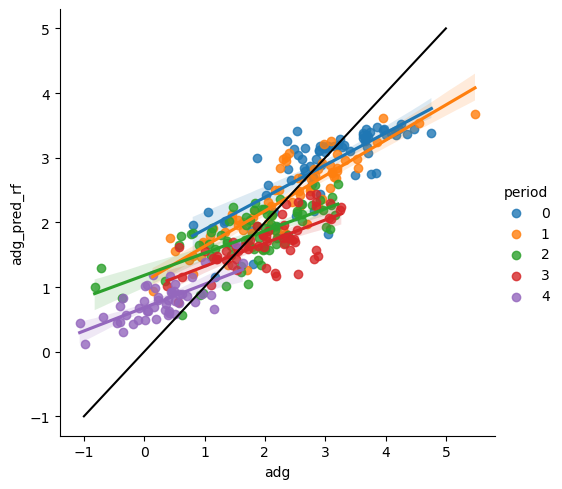

In [79]:
p = sns.lmplot(x='adg', y='adg_pred_rf', hue='period', data=df_wts_all_mean)
for ax in p.axes.flatten():
    ax.plot(np.arange(-1, 6), np.arange(-1, 6), color='black')

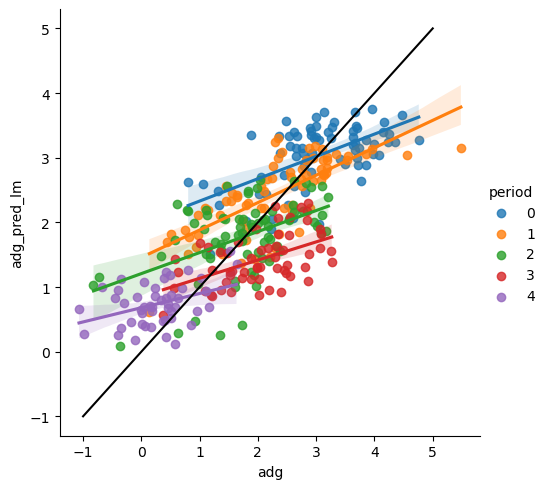

In [80]:
p = sns.lmplot(x='adg', y='adg_pred_lm', hue='period', data=df_wts_all_mean)
for ax in p.axes.flatten():
    ax.plot(np.arange(-1, 6), np.arange(-1, 6), color='black')

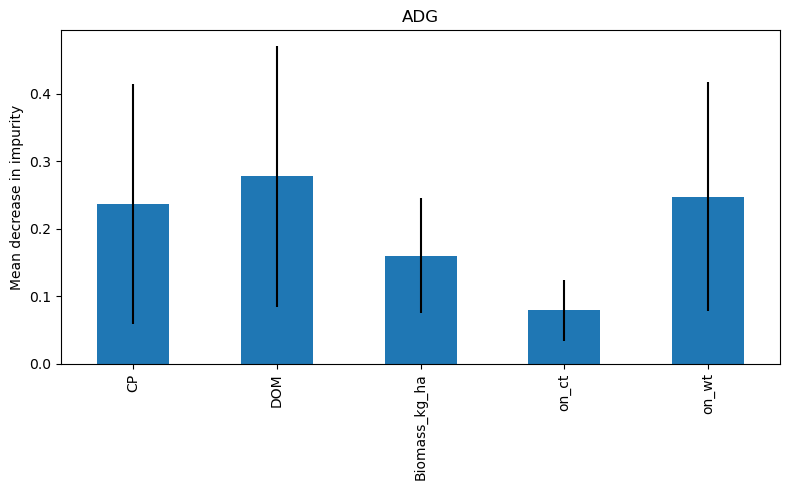

In [81]:
adg_importances = rf_adg_fnl.named_steps['RF'].feature_importances_
adg_importances_std = np.std([tree.feature_importances_ for tree in rf_adg_fnl.named_steps['RF'].estimators_], axis=0)
ps_adg_importances = pd.Series(adg_importances, index=feature_names)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ps_adg_importances.plot.bar(yerr=adg_importances_std, ax=axs)
axs.set_title("ADG")
axs.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [82]:
from sklearn.inspection import partial_dependence

In [83]:
def moving_average(x, w):
    xs = pd.Series(x)
    return xs.rolling(w, center=True, min_periods=1).mean()

In [84]:
pd_dict = {}
for idx, f in tqdm(enumerate(feature_names), total=len(feature_names)):
    pd_dict[f] = partial_dependence(rf_adg_fnl,
                                    df_wts_all_mean[feature_names],
                                    [idx], 
                                    percentiles=(0.0, 1.0),
                                    kind='both')
    pd_dict[f]['mean_grid_value'] = np.argmin(np.abs(pd_dict[f]['grid_values'] - df_wts_all_mean[feature_names[idx]].mean()))
    pd_dict[f]['individual_smooth'] = pd_dict[f]['individual'].squeeze().copy()
    for i in range(pd_dict[f]['individual_smooth'].shape[0]):
        pd_dict[f]['individual_smooth'][i,:] = moving_average(pd_dict[f]['individual'].squeeze()[i,:], 15)
    
    pd_dict[f]['individual_centered'] = pd_dict[f]['individual'].squeeze() - \
    pd_dict[f]['individual'].squeeze()[:,0, np.newaxis]
    pd_dict[f]['individual_centered_smooth'] = pd_dict[f]['individual_smooth'].squeeze() - \
    pd_dict[f]['individual_smooth'].squeeze()[:,0, np.newaxis]
    
    pd_dict[f]['individual_mean_centered'] = pd_dict[f]['individual'].squeeze() - \
    pd_dict[f]['individual'].squeeze()[:,pd_dict[f]['mean_grid_value'], np.newaxis]
    pd_dict[f]['individual_mean_centered_smooth'] = pd_dict[f]['individual_smooth'].squeeze() - \
    pd_dict[f]['individual_smooth'].squeeze()[:,pd_dict[f]['mean_grid_value'], np.newaxis]

  0%|          | 0/5 [00:00<?, ?it/s]

In [85]:
var_label_dict = {'CP': 'Crude Protein (%)',
                  'DOM': 'Dig. Org. Matter (%)',
                  'Biomass_kg_ha': 'Biomass (kg/ha)',
                  'forage_kg_au': 'Forage Alloc. (kg/au)',
                  'on_ct': 'Stock Count (# hd)',
                  'on_wt': 'Steer weight (kg/hd)'}

var_title_dict = {'CP': 'Crude Protein (%)',
                  'DOM': 'Dig. Org. Matter (%)',
                  'Biomass_kg_ha': 'Biomass (kg/ha)',
                  'forage_kg_au': 'Forage Alloc. (kg/au)',
                  'on_ct': 'Stock Count (# hd)',
                  'on_wt': 'Steer weight (kg/hd)'}

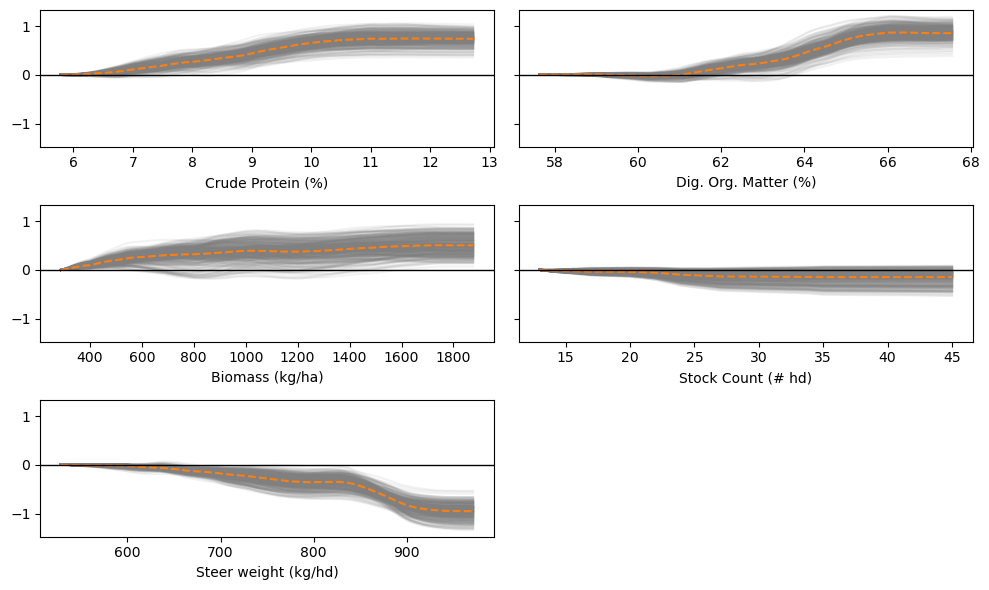

In [86]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(feature_names)/2)), 
                        ncols=2, 
                        figsize=(10, 6), sharey=True)
for idx, f in enumerate(feature_names):
    for i in range(pd_dict[f]['individual_centered_smooth'].shape[0]):
        axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                pd_dict[f]['individual_centered_smooth'][i, :], color='grey', alpha=0.1)
    axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                            np.mean(pd_dict[f]['individual_centered_smooth'], axis=0), 
                            color='tab:orange', linestyle='dashed')
for idx, f in enumerate(feature_names):
    axs.flatten()[idx].set_ylim(min([np.min(pd_dict[f]['individual_centered_smooth']) for f in feature_names])*1.1,
                                max([np.max(pd_dict[f]['individual_centered_smooth']) for f in feature_names])*1.1)
    axs.flatten()[idx].axhline(y=0, color='black', linewidth=1)
    axs.flatten()[idx].set_xlabel(var_label_dict[feature_names[idx]])
for ax in axs.flatten()[len(feature_names):]:
    fig.delaxes(ax)
fig.tight_layout()

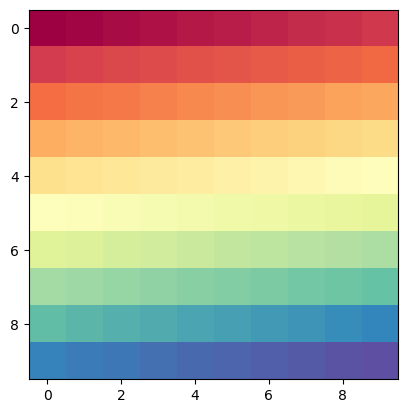

In [87]:
center='_centered'
import matplotlib.colors as mcolors
norm = mcolors.CenteredNorm()
cmap = sns.color_palette("Spectral", as_cmap=True)
#cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(df_wts_all_mean)))
ax_tmp = plt.imshow(np.arange(100).reshape(10,10), cmap)

In [88]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as ptch
import matplotlib.transforms as mtrans

  0%|          | 0/5 [00:00<?, ?it/s]

/local/scratch/sean.kearney/16434015/ipykernel_1667771/3552568777.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=1.75, h_pad=2.25)


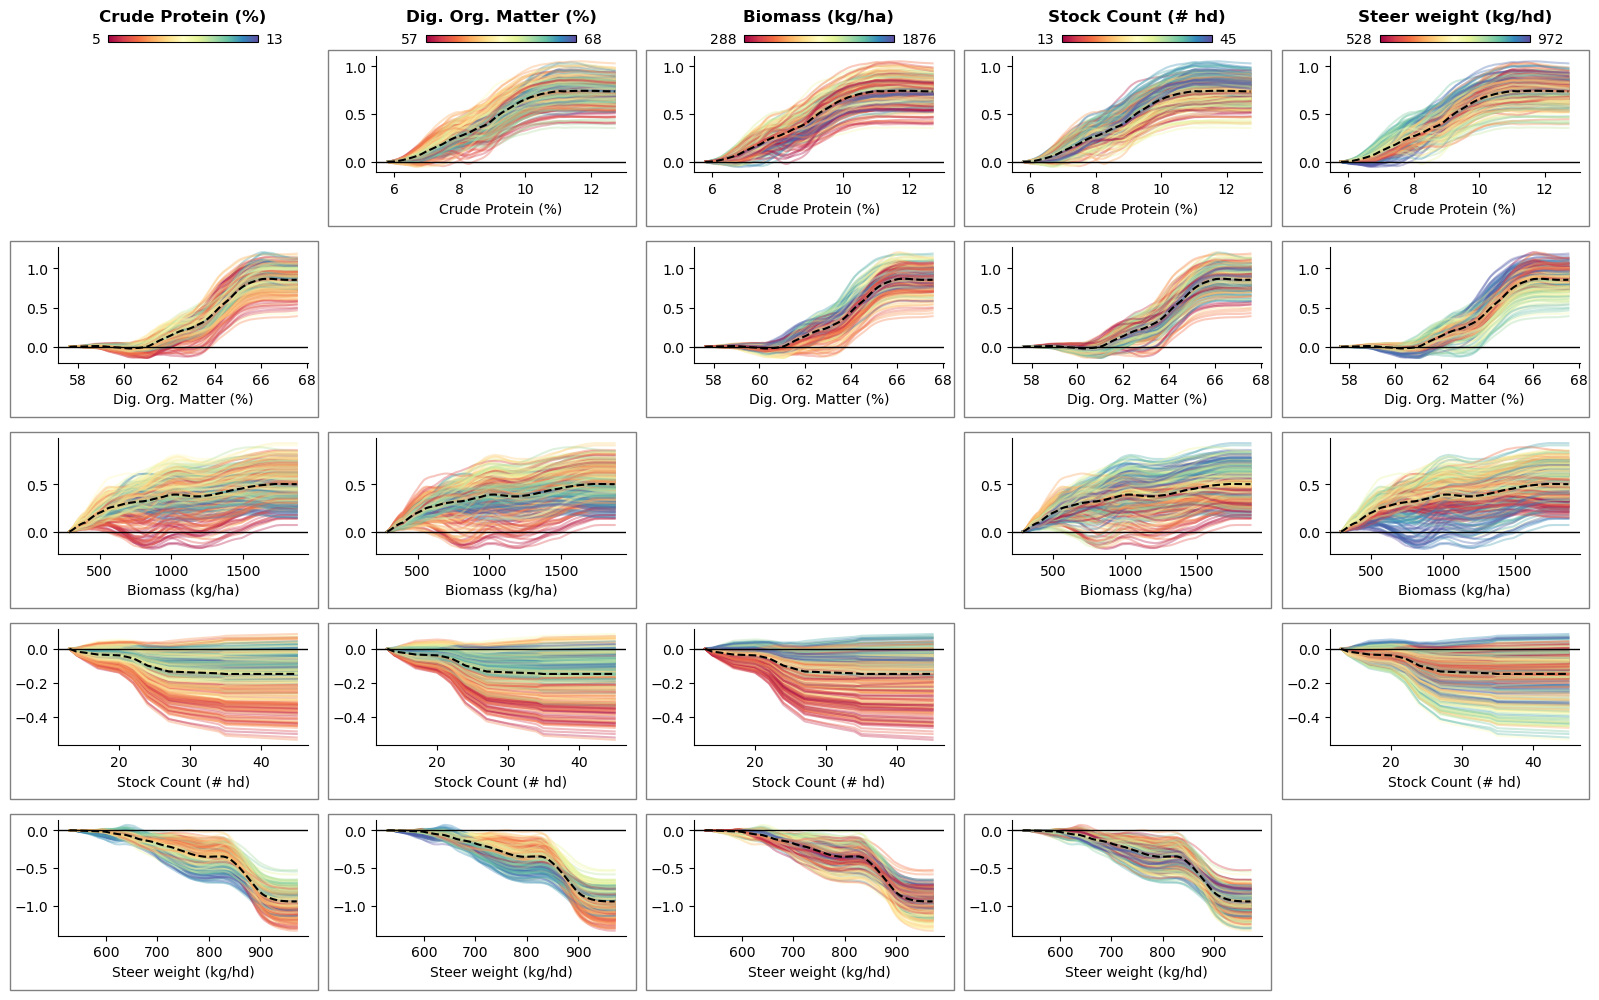

In [89]:
fig, axs = plt.subplots(ncols=len(feature_names), nrows=len(feature_names), 
                        figsize=(16,10))
fig.canvas.draw()
axs_ins = []
for idx_i, f_i in tqdm(enumerate(feature_names), total=len(feature_names)):
    for idx_j, f_j in enumerate(feature_names):
        if idx_i == 0:
            axs[idx_i, idx_j].set_title(var_label_dict[f_j], fontweight='bold', y=1.0, pad=25)
        if idx_i == idx_j:
            #fig.delaxes(axs[idx_i,idx_j])
            #axs[idx_i,idx_j].axis('off')
            #if idx_i == 0:
            #    axs[idx_i, idx_j].set_title(var_label_dict[f_j], fontweight='bold')
            axs[idx_i,idx_j].get_xaxis().set_visible(False)
            axs[idx_i,idx_j].get_yaxis().set_visible(False)
            continue
        else:
            f_j_centered = df_wts_all_mean[f_j] - df_wts_all_mean[f_j].mean()
            f_j_norm = f_j_centered.apply(lambda x: norm(x)).sort_values()
            f_j_norm = f_j_norm.reset_index()
            for i in range(pd_dict[feature_names[0]]['individual' + center + '_smooth'].shape[0]):
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual' + center + '_smooth'][i, :], 
                                       color=colors[f_j_norm[f_j_norm['index'] == i].index.values],
                                       alpha=0.35)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                    np.mean(pd_dict[f_i]['individual' + center + '_smooth'], axis=0), 
                    color='black', linestyle='dashed')
            axs[idx_i, idx_j].set_xlabel(var_label_dict[f_i])
            axs[idx_i, idx_j].axhline(y=0, color='black', linewidth=1)
            axs[idx_i, idx_j].spines['top'].set_color('none')
            axs[idx_i, idx_j].spines['right'].set_color('none')
            #axs[idx_i, idx_j].set_title(f_j)
for i in range(len(feature_names)):
    axs_ins.append(inset_axes(axs[0, i],
                              width="60%",  
                              height="6%",
                              loc='upper center',
                              borderpad=-1.5
                             ))
    axs_ins
    cb = plt.colorbar(ax_tmp, cax=axs_ins[i], location='bottom', orientation='horizontal', ticks=[])
    cb.ax.text(-0.05, 0.4, str(int(np.floor(df_wts_all_mean[feature_names[i]].min()))), 
               transform=cb.ax.transAxes, va='center', ha='right')
    cb.ax.text(1.05, 0.4, str(int(np.ceil(df_wts_all_mean[feature_names[i]].max()))),
               transform=cb.ax.transAxes, va='center', ha='left')
fig.tight_layout(w_pad=1.75, h_pad=2.25)
box_pad = 0.03
for idx_i in range(len(feature_names)):
    for idx_j in range(len(feature_names)):
        ax = axs[idx_i, idx_j]
        if idx_i == idx_j:
            ax.set_frame_on(False)
            continue
        else:
            #if (idx_i == 0) & (idx_j > 1):
            #    ax.yaxis.set_ticklabels([])
            #elif (idx_i > 0) * (idx_j > 0):
            #    ax.yaxis.set_ticklabels([])
            pos = ax.get_position()
            # Create a rectangle patch
            rect = ptch.Rectangle((pos.x0-box_pad, pos.y0-box_pad*1.8), 
                                  pos.width+box_pad+box_pad*0.2, pos.height+box_pad*1.8+box_pad*0.2,
                                  linewidth=1, edgecolor='grey', facecolor='none', transform=fig.transFigure)
            # Add the rectangle to the figure
            fig.patches.append(rect)

#for yy in [0.203, 0.402, 0.602, 0.801]:
#    line = plt.Line2D([yy, yy], [0,1], transform=fig.transFigure, color="black")
#    fig.add_artist(line)

  0%|          | 0/5 [00:00<?, ?it/s]

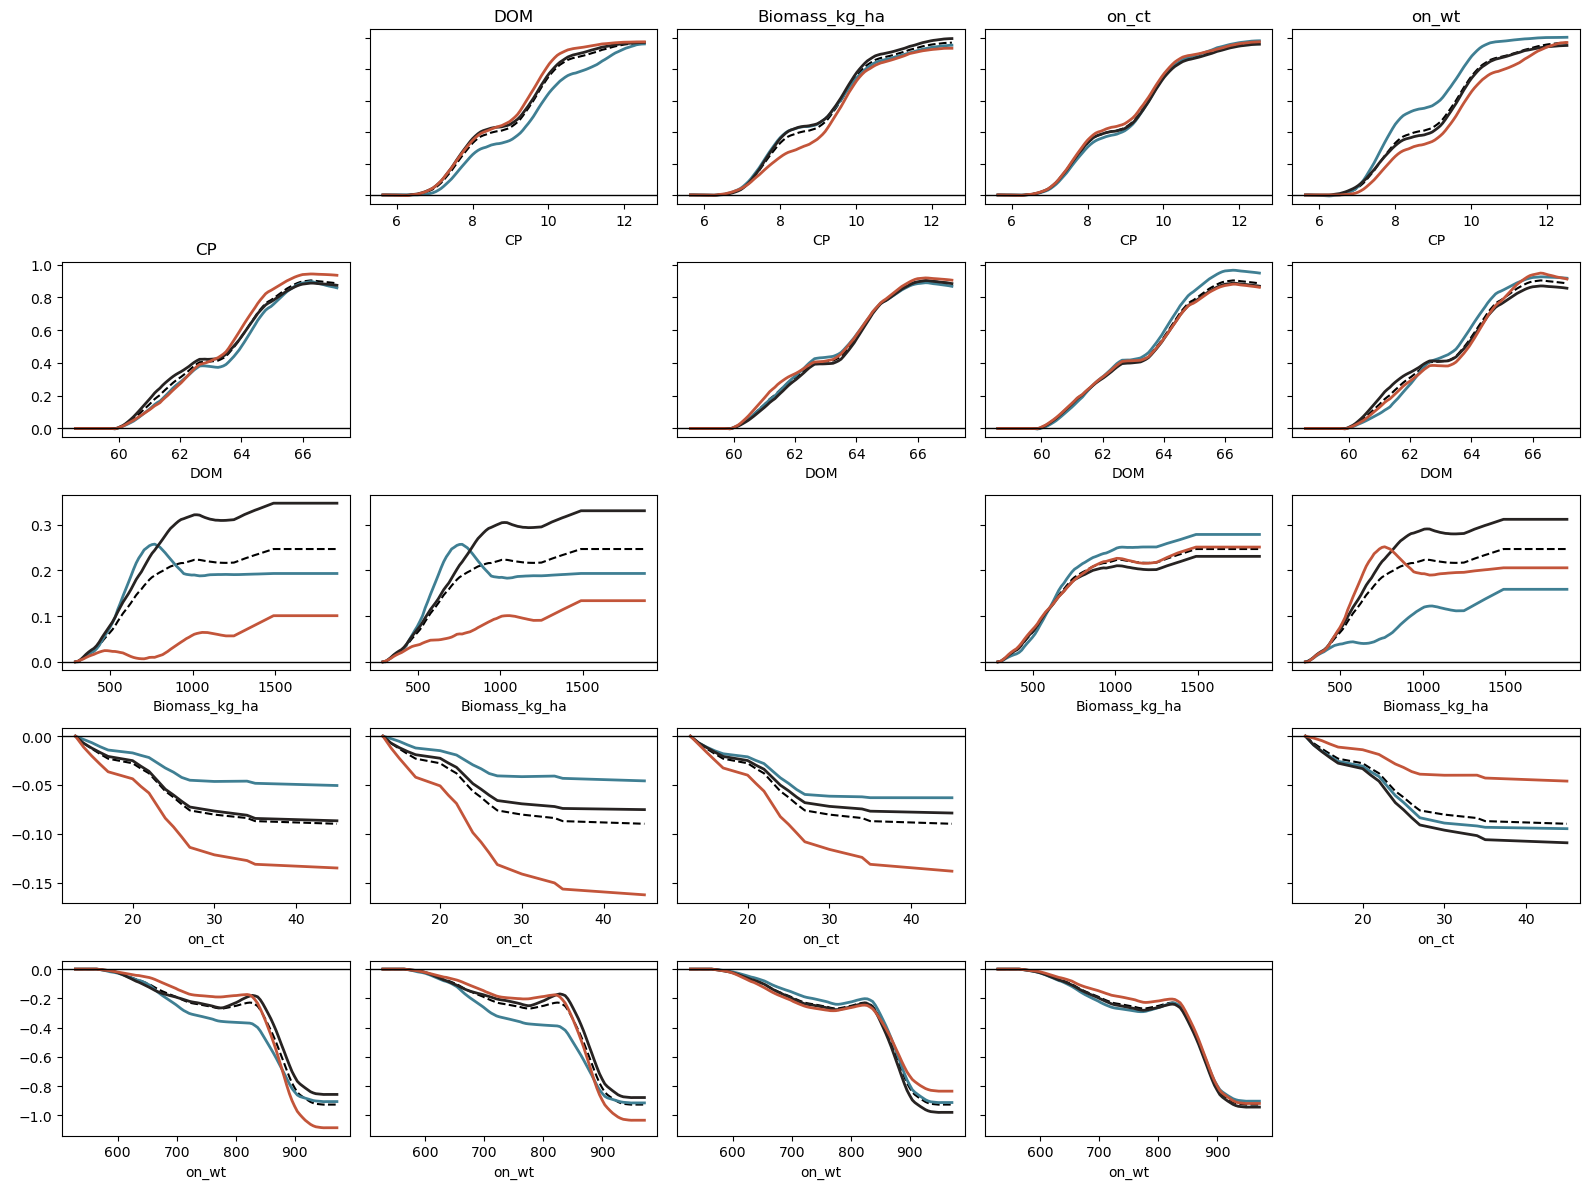

In [182]:
center='_centered'
#cmap = mpl.colormaps['cividis']
cmap = sns.diverging_palette(h_neg=220, h_pos=20, l=50, center='dark', as_cmap=True)
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 3))
fig, axs = plt.subplots(ncols=len(feature_names), nrows=len(feature_names), figsize=(16,12), sharey='row')
for idx_i, f_i in tqdm(enumerate(feature_names), total=len(feature_names)):
    for idx_j, f_j in enumerate(feature_names):
        if idx_i == idx_j:
            fig.delaxes(axs[idx_i,idx_j])
            continue
        else:
            f_j_upr = df_wts_all_mean[f_j].quantile(0.75)
            f_j_lwr = df_wts_all_mean[f_j].quantile(0.25)
            #for i in range(pd_dict['Biomass_kg_ha']['individual' + center + '_smooth'].shape[0]):
            #    axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
            #            pd_dict[f_i]['individual' + center + '_smooth'][i, :], 
            #                           color='grey', 
            #                           linewidth=1,
            #                           alpha=0.05)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                    np.mean(pd_dict[f_i]['individual' + center + '_smooth'], axis=0), 
                    color='black', linestyle='dashed')
            low_idxs = df_wts_all_mean[(df_wts_all_mean[f_j] > f_j_upr)].index.values
            med_idxs = df_wts_all_mean[(df_wts_all_mean[f_j] <= f_j_upr) & (df_wts_all_mean[f_j] > f_j_lwr)].index.values
            hi_idxs = df_wts_all_mean[(df_wts_all_mean[f_j] < f_j_lwr)].index.values
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                                   np.mean(
                                       pd_dict[f_i]['individual' + center + '_smooth'][low_idxs, :],
                                       axis=0), 
                                   color=colors[0], 
                                   linestyle='solid',
                                   linewidth=2,
                                   alpha=1.0)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                                   np.mean(
                                       pd_dict[f_i]['individual' + center + '_smooth'][med_idxs, :],
                                       axis=0), 
                                   color=colors[1], 
                                   linestyle='solid',
                                   linewidth=2,
                                   alpha=1.0)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                                   np.mean(
                                       pd_dict[f_i]['individual' + center + '_smooth'][hi_idxs, :],
                                       axis=0), 
                                   color=colors[2], 
                                   linestyle='solid',
                                   linewidth=2,
                                   alpha=1.0)
            
            axs[idx_i, idx_j].set_xlabel(f_i)
        if idx_i == 0 or ((idx_i == 1) & (idx_j == 0)):
            axs[idx_i, idx_j].set_title(f_j)
for ax in axs.flatten():
    #ax.set_ylim(-1.4, 1.6)
    ax.axhline(y=0, color='black', linewidth=1)
#axs[0,1].set_yticklabels(labels_00)
fig.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]

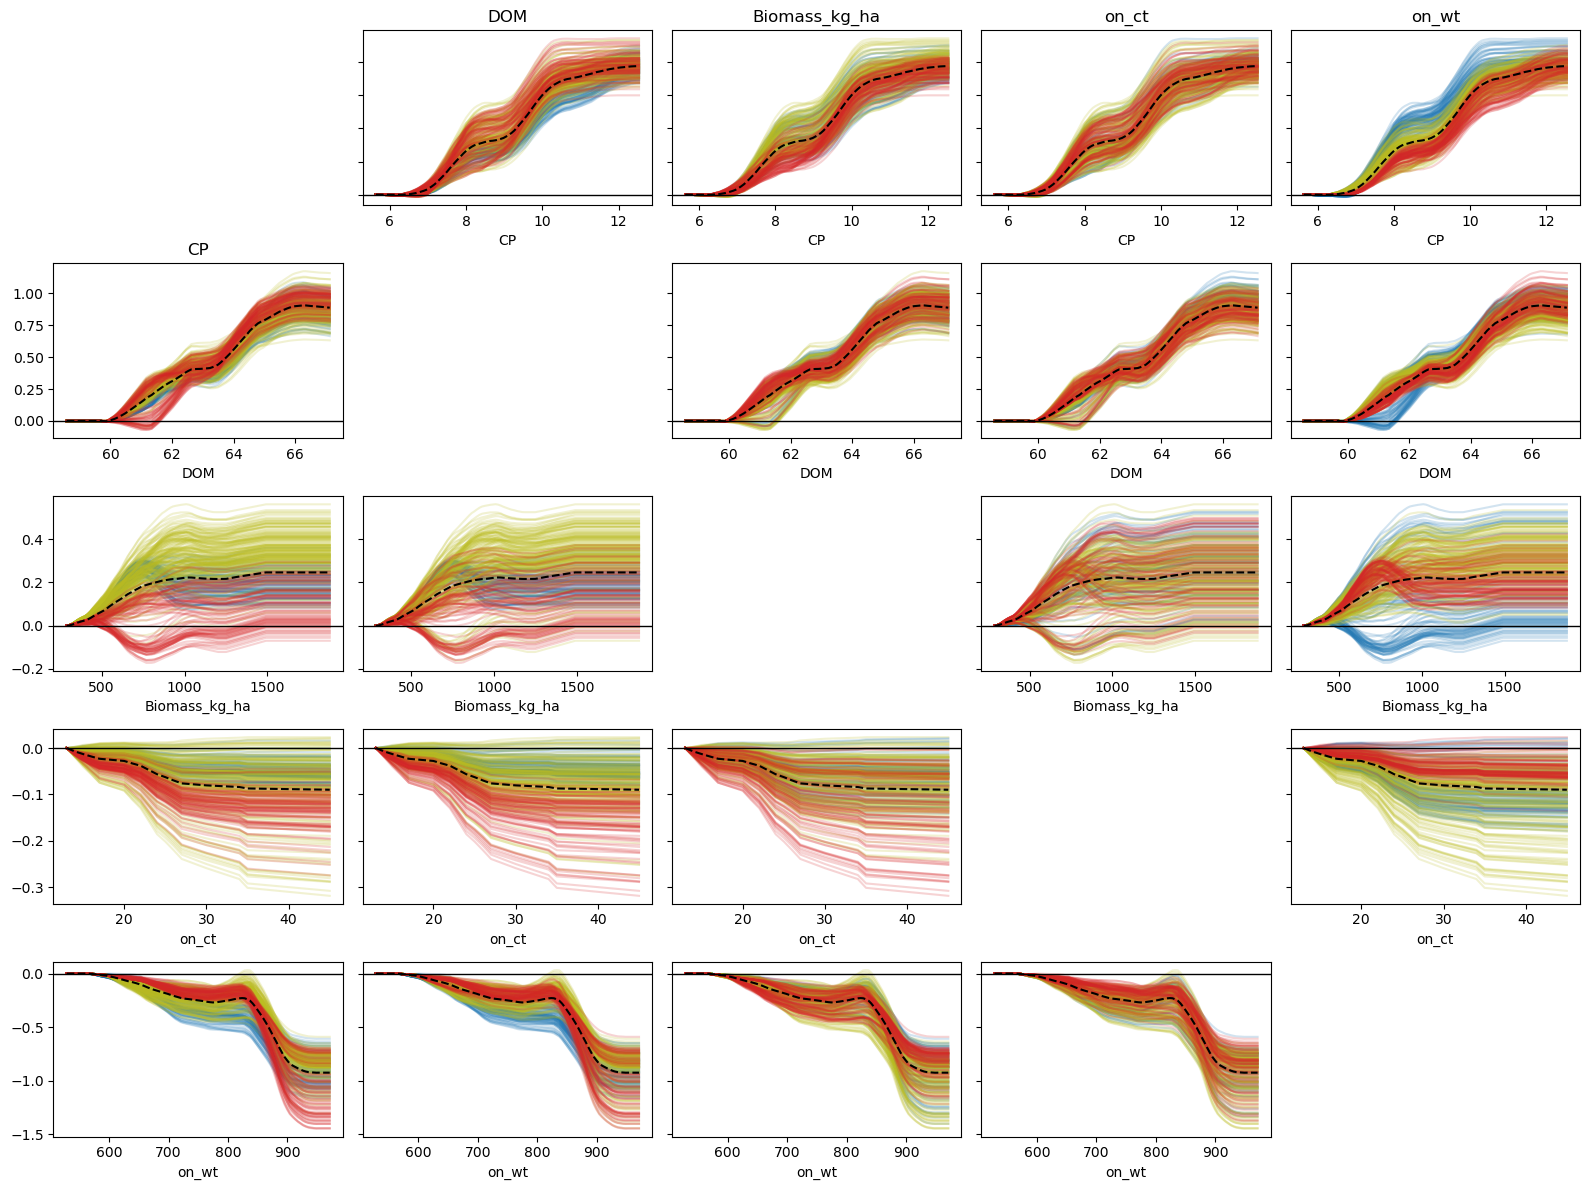

In [184]:
center='_centered'
fig, axs = plt.subplots(ncols=len(feature_names), nrows=len(feature_names), figsize=(16,12), sharey='row')
for idx_i, f_i in tqdm(enumerate(feature_names), total=len(feature_names)):
    for idx_j, f_j in enumerate(feature_names):
        if idx_i == idx_j:
            fig.delaxes(axs[idx_i,idx_j])
            continue
        else:
            f_j_upr = df_wts_all_mean[f_j].quantile(0.75)
            f_j_lwr = df_wts_all_mean[f_j].quantile(0.25)
            #for i in range(pd_dict['Biomass_kg_ha']['individual' + center + '_smooth'].shape[0]):
            #    axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
            #            pd_dict[f_i]['individual' + center + '_smooth'][i, :], color='grey', alpha=0.1)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] > f_j_upr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual' + center + '_smooth'][idx, :], color='tab:blue', alpha=0.2)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] <= f_j_upr) & (df_wts_all_mean[f_j] > f_j_lwr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual' + center + '_smooth'][idx, :], color='tab:olive', alpha=0.2)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] < f_j_lwr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual' + center + '_smooth'][idx, :], color='tab:red', alpha=0.2)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                    np.mean(pd_dict[f_i]['individual' + center + '_smooth'], axis=0), 
                    color='black', linestyle='dashed')
            axs[idx_i, idx_j].set_xlabel(f_i)
        if idx_i == 0 or ((idx_i == 1) & (idx_j == 0)):
            axs[idx_i, idx_j].set_title(f_j)
for ax in axs.flatten():
    #ax.set_ylim(-1.4, 1.6)
    ax.axhline(y=0, color='black', linewidth=1)
#axs[0,1].set_yticklabels(labels_00)
fig.tight_layout()

In [454]:
[item.get_text() for item in axs[0,0].get_yticklabels()]

['−0.5', '0.0', '0.5', '1.0', '1.5']

In [ ]:
adg_grid_res = 20

fig, axs = plt.subplots(nrows=len(feature_names), ncols=len(feature_names),
                        figsize=(18, 18), sharex=False, sharey=False)
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if i >= j:
            fig.delaxes(axs[i,j])
            continue
        else:
            PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                                    df_wts_all_mean[feature_names],
                                                    [(i, j)], 
                                                    grid_resolution=adg_grid_res,
                                                    n_jobs=-1,
                                                    ax=axs[i,j])
plt.tight_layout()

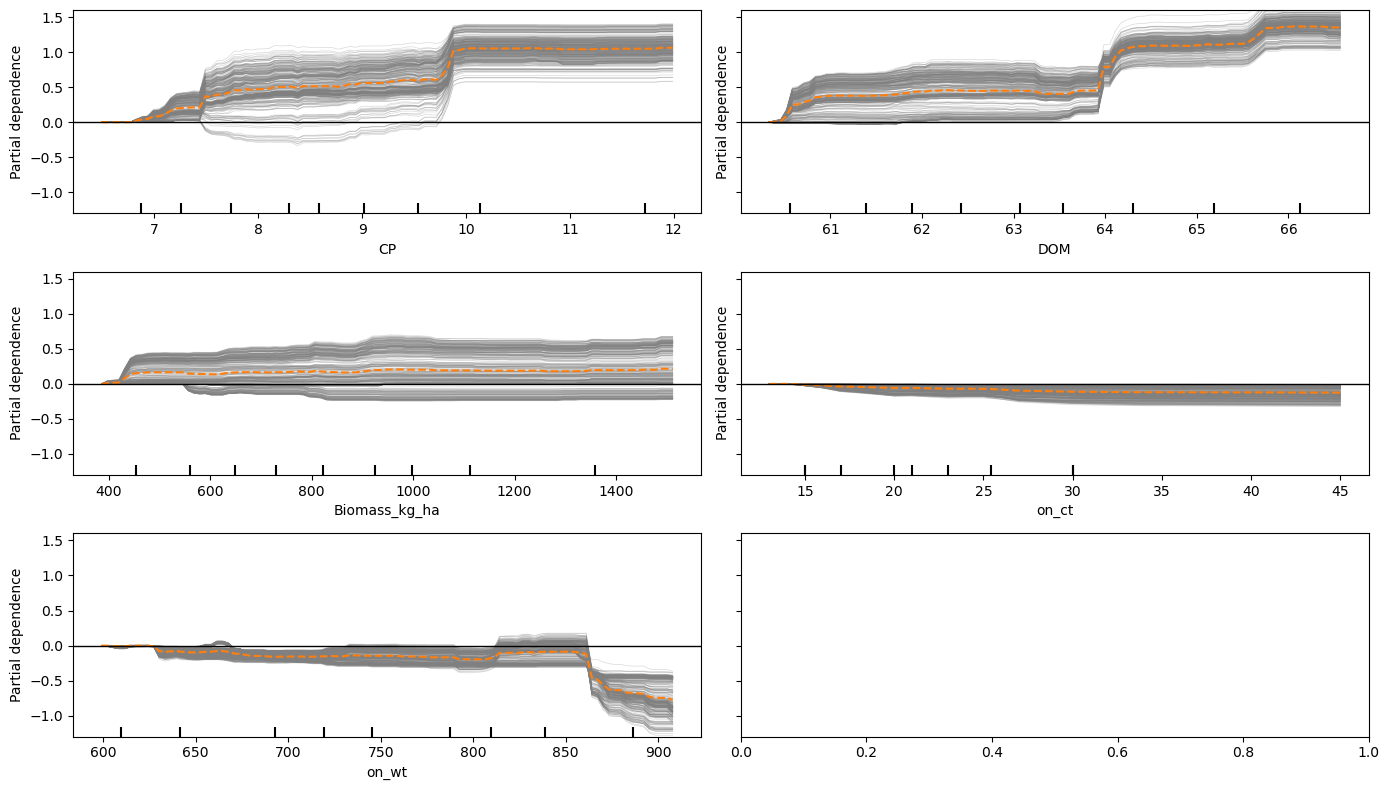

In [435]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(feature_names)/2)), 
                        ncols=2, 
                        figsize=(14, 8), sharey=True)
for i in range(len(feature_names)):
    PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                            df_wts_all_mean[feature_names],
                                            [i], 
                                            kind='both',
                                            centered=True,
                                            ice_lines_kw={'color': 'grey'},
                                            ax=[axs.flatten()[i]],
                                            n_jobs=-1)
for ax in axs.flatten()[:len(feature_names)]:
    ax.set_ylim(-1.3, 1.6)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.get_legend().remove()
fig.tight_layout()

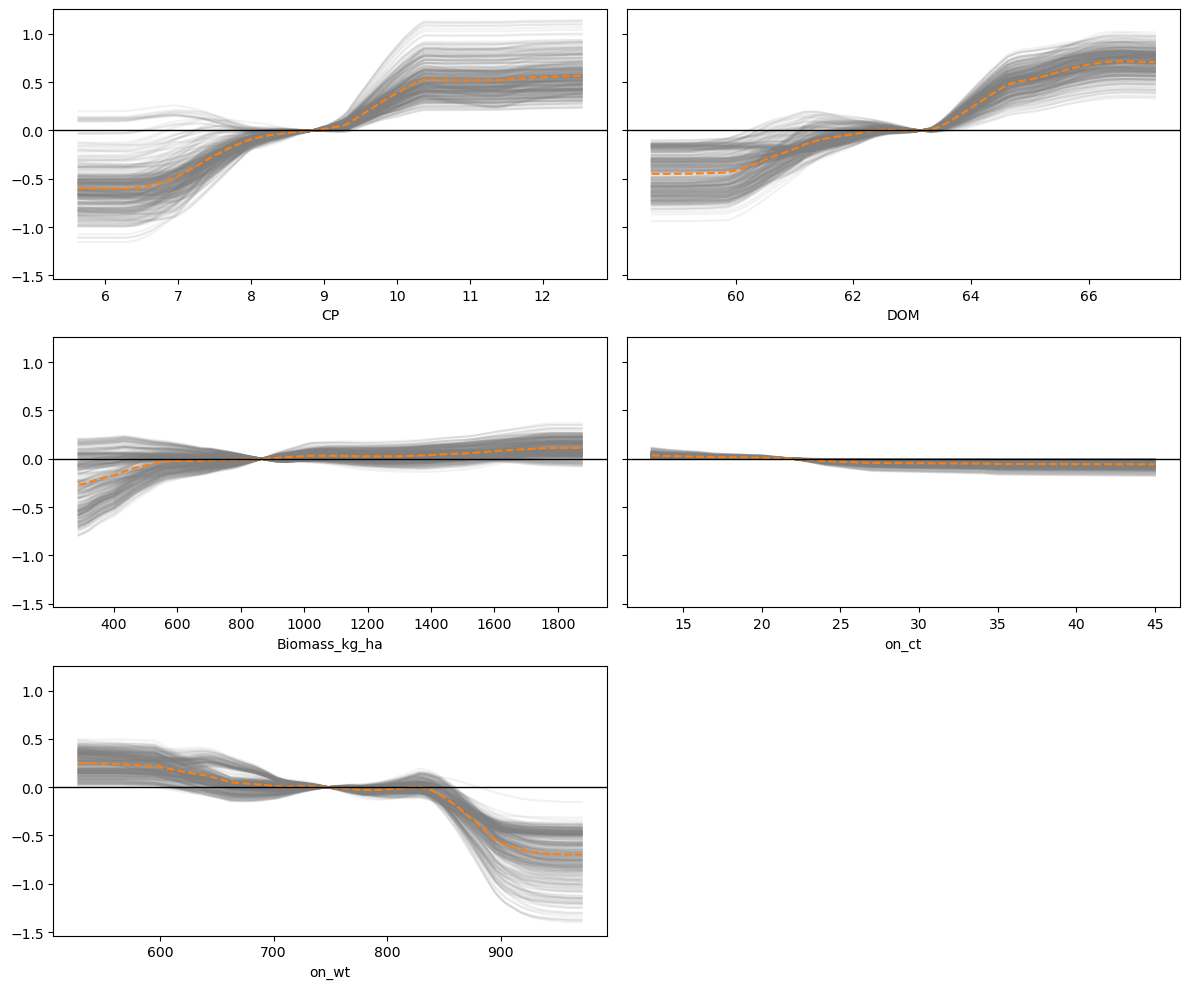

In [198]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(feature_names)/2)), 
                        ncols=2, 
                        figsize=(12, 10), sharey=True)
for idx, f in enumerate(feature_names):
    for i in range(pd_dict[f]['individual_mean_centered'].shape[0]):
        axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                pd_dict[f]['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
    axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                            np.mean(pd_dict[f]['individual_mean_centered_smooth'], axis=0), 
                            color='tab:orange', linestyle='dashed')
for idx, f in enumerate(feature_names):
    axs.flatten()[idx].set_ylim(min([np.min(pd_dict[f]['individual_mean_centered_smooth']) for f in feature_names])*1.1,
                                max([np.max(pd_dict[f]['individual_mean_centered_smooth']) for f in feature_names])*1.1)
    axs.flatten()[idx].axhline(y=0, color='black', linewidth=1)
    axs.flatten()[idx].set_xlabel(feature_names[idx])
for ax in axs.flatten()[len(feature_names):]:
    fig.delaxes(ax)
fig.tight_layout()

100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


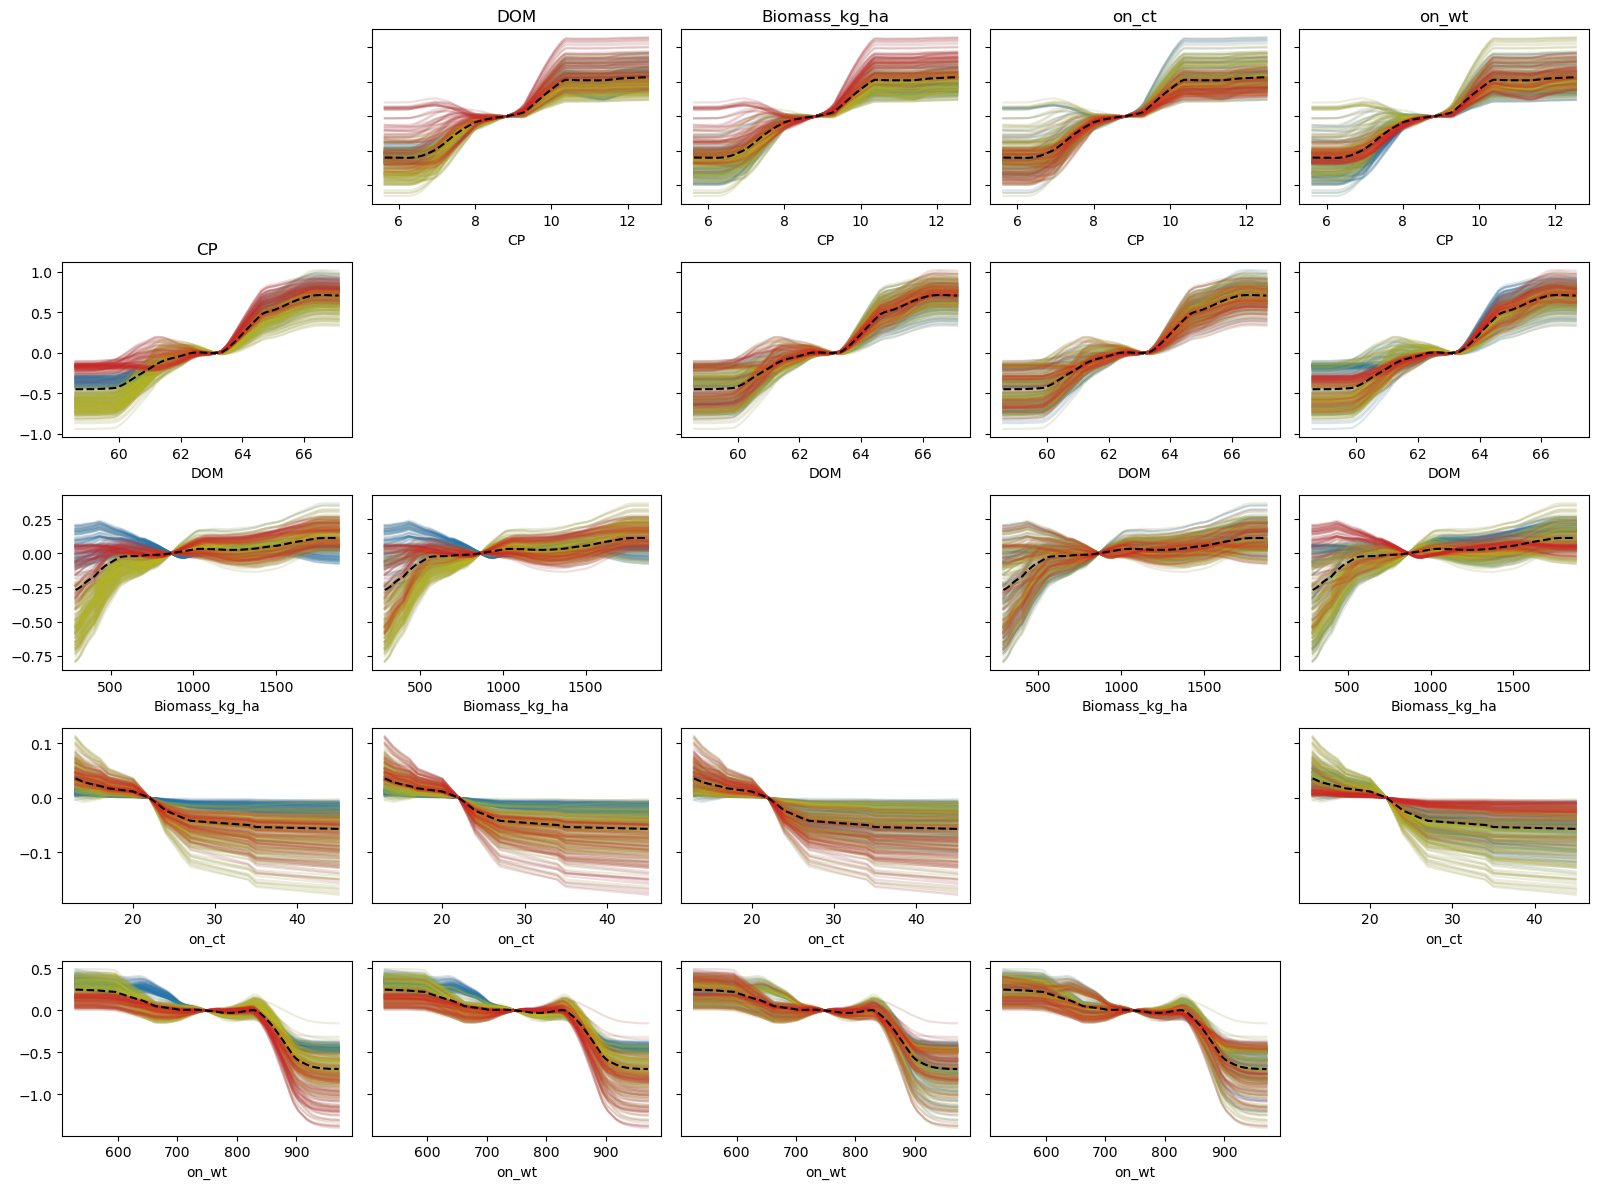

In [199]:
fig, axs = plt.subplots(ncols=len(feature_names), nrows=len(feature_names), figsize=(16,12), sharey='row')
for idx_i, f_i in tqdm(enumerate(feature_names), total=len(feature_names)):
    for idx_j, f_j in enumerate(feature_names):
        if idx_i == idx_j:
            fig.delaxes(axs[idx_i,idx_j])
            continue
        else:
            f_j_upr = df_wts_all_mean[f_j].quantile(0.75)
            f_j_lwr = df_wts_all_mean[f_j].quantile(0.25)
            for i in range(pd_dict['Biomass_kg_ha']['individual_mean_centered'].shape[0]):
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] > f_j_upr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual_mean_centered_smooth'][idx, :], color='tab:blue', alpha=0.1)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] <= f_j_upr) & (df_wts_all_mean[f_j] > f_j_lwr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual_mean_centered_smooth'][idx, :], color='tab:olive', alpha=0.1)
            for idx in df_wts_all_mean[(df_wts_all_mean[f_j] < f_j_lwr)].index.values:
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual_mean_centered_smooth'][idx, :], color='tab:red', alpha=0.1)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                    np.mean(pd_dict[f_i]['individual_mean_centered_smooth'], axis=0), 
                    color='black', linestyle='dashed')
            axs[idx_i, idx_j].set_xlabel(f_i)
        if idx_i == 0 or ((idx_i == 1) & (idx_j == 0)):
            axs[idx_i, idx_j].set_title(f_j)
fig.tight_layout()

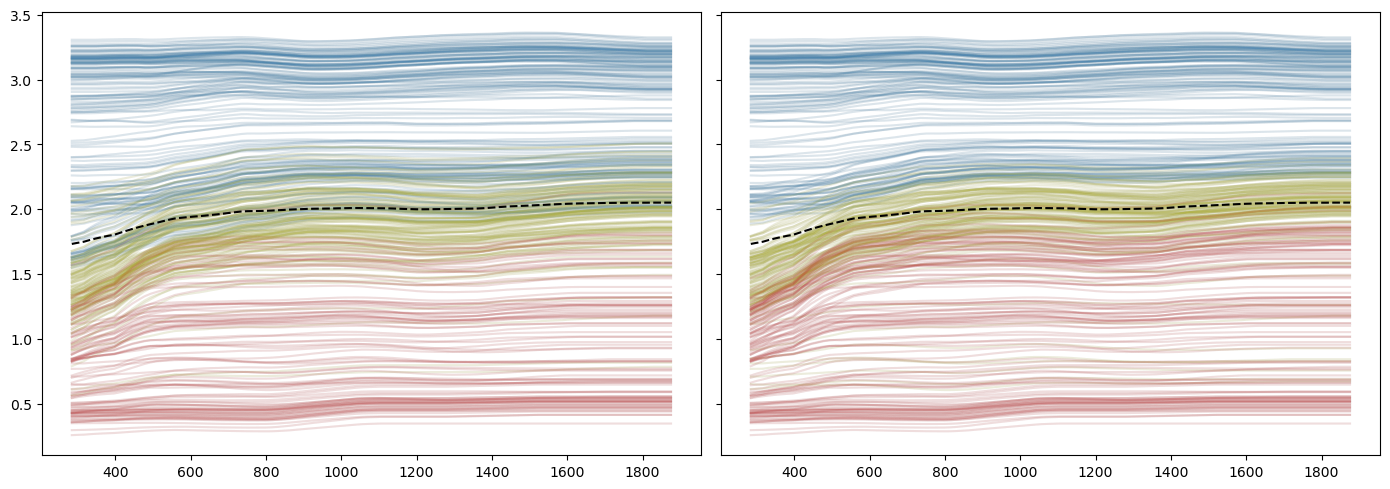

In [671]:
fig, axs = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
for i in range(pd_dict['Biomass_kg_ha']['individual'].squeeze().shape[0]):
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] > 9)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] <= 9) & (df_wts_all_mean['CP'] > 7.5)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] < 7.5)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
        np.mean(pd_dict['Biomass_kg_ha']['individual_smooth'], axis=0), 
        color='black', linestyle='dashed')

for i in range(pd_dict['Biomass_kg_ha']['individual'].squeeze().shape[0]):
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] > 64)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] <= 64) & (df_wts_all_mean['DOM'] > 62)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] < 62)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
        np.mean(pd_dict['Biomass_kg_ha']['individual_smooth'], axis=0), 
        color='black', linestyle='dashed')
fig.tight_layout()
#for ax in axs.flatten():
#    ax.axhline(y=0, linestyle='solid', linewidth=1, color='black')

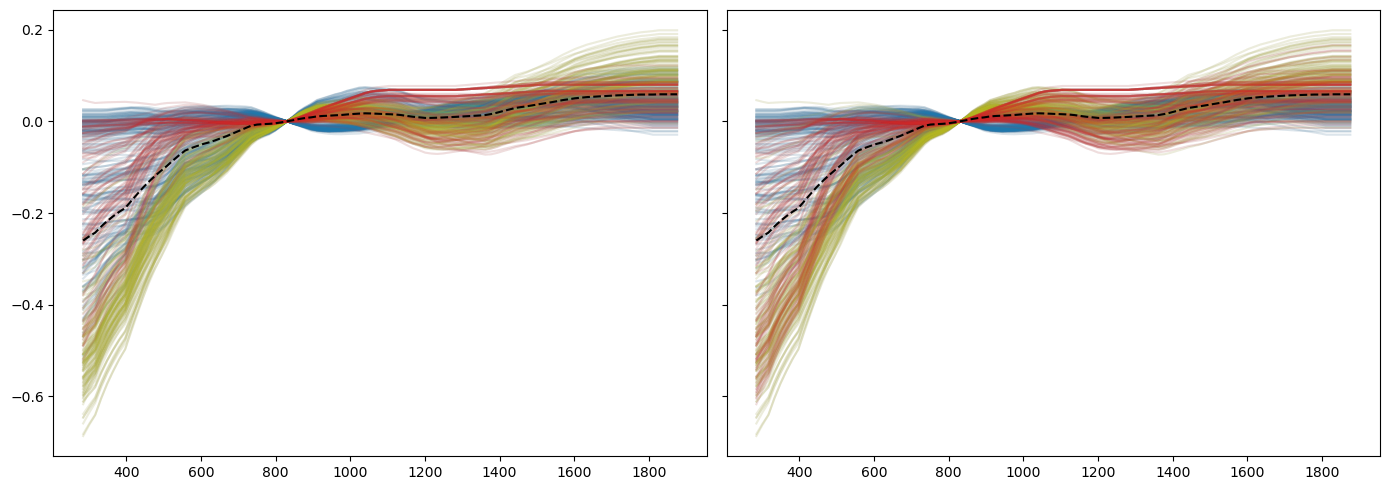

In [664]:
fig, axs = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
for i in range(pd_dict['Biomass_kg_ha']['individual_mean_centered'].shape[0]):
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] > 9)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] <= 9) & (df_wts_all_mean['CP'] > 7.5)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] < 7.5)].index.values:
    axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[0].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
        np.mean(pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'], axis=0), 
        color='black', linestyle='dashed')

for i in range(pd_dict['Biomass_kg_ha']['individual_mean_centered'].shape[0]):
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] > 64)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] <= 64) & (df_wts_all_mean['DOM'] > 62)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['DOM'] < 62)].index.values:
    axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
            pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[1].plot(pd_dict['Biomass_kg_ha']['grid_values'][0],
        np.mean(pd_dict['Biomass_kg_ha']['individual_mean_centered_smooth'], axis=0), 
        color='black', linestyle='dashed')
fig.tight_layout()
#for ax in axs.flatten():
#    ax.axhline(y=0, linestyle='solid', linewidth=1, color='black')

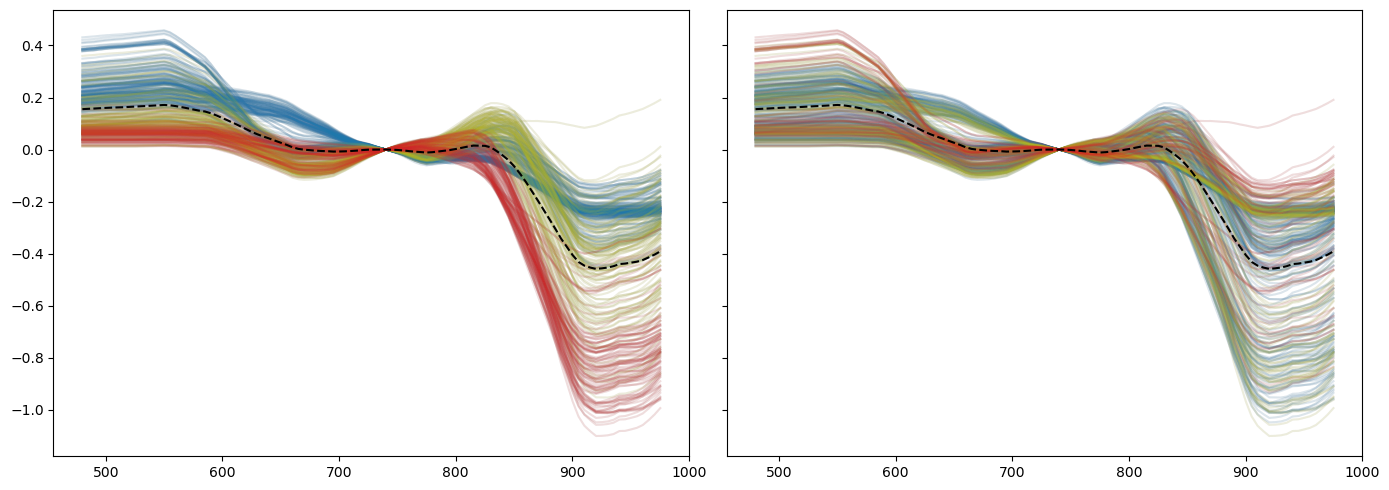

In [666]:
fig, axs = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
for i in range(pd_dict['on_wt']['individual_mean_centered'].shape[0]):
    axs[0].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] > 9)].index.values:
    axs[0].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] <= 9) & (df_wts_all_mean['CP'] > 7.5)].index.values:
    axs[0].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['CP'] < 7.5)].index.values:
    axs[0].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[0].plot(pd_dict['on_wt']['grid_values'][0],
        np.mean(pd_dict['on_wt']['individual_mean_centered_smooth'], axis=0), 
        color='black', linestyle='dashed')

for i in range(pd_dict['on_wt']['individual_mean_centered'].shape[0]):
    axs[1].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][i, :], color='grey', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['Biomass_kg_ha'] > 800)].index.values:
    axs[1].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:blue', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['Biomass_kg_ha'] <= 800) & (df_wts_all_mean['Biomass_kg_ha'] > 500)].index.values:
    axs[1].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:olive', alpha=0.1)
for idx in df_wts_all_mean[(df_wts_all_mean['Biomass_kg_ha'] < 500)].index.values:
    axs[1].plot(pd_dict['on_wt']['grid_values'][0],
            pd_dict['on_wt']['individual_mean_centered_smooth'][idx, :], color='tab:red', alpha=0.1)
axs[1].plot(pd_dict['on_wt']['grid_values'][0],
        np.mean(pd_dict['on_wt']['individual_mean_centered_smooth'], axis=0), 
        color='black', linestyle='dashed')
fig.tight_layout()

In [638]:
test = partial_dependence(rf_adg_fnl,
                   df_wts_all_mean[feature_names],
                   [0,2], 
                   percentiles=(0.0, 1.0),
                   kind='average')

In [654]:
test['average'].shape

(1, 100, 100)

In [650]:
from matplotlib import transforms  # noqa

In [661]:
adg_levels = np.arange(0.5, 3.5, 0.25)

<a list of 6 text.Text objects>

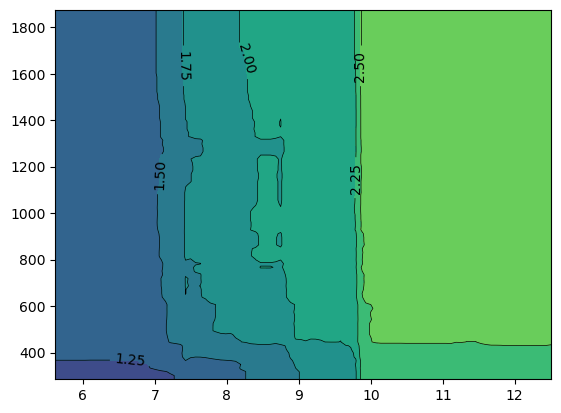

In [662]:
fig, ax = plt.subplots()
XX, YY = np.meshgrid(test['grid_values'][0], test['grid_values'][1])
Z = test['average'].squeeze().T
CS = ax.contour(XX, YY, Z, levels=adg_levels, linewidths=0.5, colors="k")
ax.contourf(
    XX,
    YY,
    Z,
    levels=adg_levels,
    vmax=adg_levels[-1],
    vmin=adg_levels[0]
)
ax.clabel(CS, fmt="%2.2f", colors="k", fontsize=10, inline=True)

In [ ]:
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
# create the decile line for the vertical axis
xlim, ylim = ax.get_xlim(), ax.get_ylim()
vlines_idx = np.unravel_index(pd_plot_idx, self.deciles_vlines_.shape)
self.deciles_vlines_[vlines_idx] = ax.vlines(
    self.deciles[feature_idx[0]],
    0,
    0.05,
    transform=trans,
    color="k",
)
# create the decile line for the horizontal axis
hlines_idx = np.unravel_index(pd_plot_idx, self.deciles_hlines_.shape)
self.deciles_hlines_[hlines_idx] = ax.hlines(
    self.deciles[feature_idx[1]],
    0,
    0.05,
    transform=trans,
    color="k",
)
# reset xlim and ylim since they are overwritten by hlines and
# vlines
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# set xlabel if it is not already set
if not ax.get_xlabel():
    ax.set_xlabel(self.feature_names[feature_idx[0]])
ax.set_ylabel(self.feature_names[feature_idx[1]])

In [539]:
pd_cp = partial_dependence(rf_adg_fnl,
                           df_wts_all_mean[feature_names],
                           [0], 
                           percentiles=(0.0, 1.0),
                           #feature_names,
                           kind='both')

In [540]:
pd_bm = partial_dependence(rf_adg_fnl,
                           df_wts_all_mean[feature_names],
                           [2], 
                           percentiles=(0.0, 1.0),
                           #feature_names,
                           kind='both')

In [550]:
idx_mean_bm = np.argmin(np.abs(pd_bm['grid_values'] - df_wts_all_mean[feature_names[2]].mean()))

In [601]:
pd_bm['individual_smooth'] = pd_bm['individual'].squeeze().copy()
for i in range(pd_bm['individual_smooth'].shape[0]):
    pd_bm['individual_smooth'][i,:] = moving_average(pd_bm['individual'].squeeze()[i,:], 15)

In [602]:
pd_bm['individual_mean_centered'] = pd_bm['individual'].squeeze() - pd_bm['individual'].squeeze()[:,idx_mean_bm, np.newaxis]
pd_bm['individual_mean_centered_smooth'] = pd_bm['individual_smooth'].squeeze() - pd_bm['individual_smooth'].squeeze()[:,idx_mean_bm, np.newaxis]
#pd_bm['individual_mean_centered_smooth'] = pd_bm['individual_mean_centered'].copy()
#for i in range(pd_bm['individual_mean_centered_smooth'].shape[0]):
#    pd_bm['individual_mean_centered_smooth'][i,:] = moving_average(pd_bm['individual_mean_centered'][i,:], 15)

(0.0, 3.0)

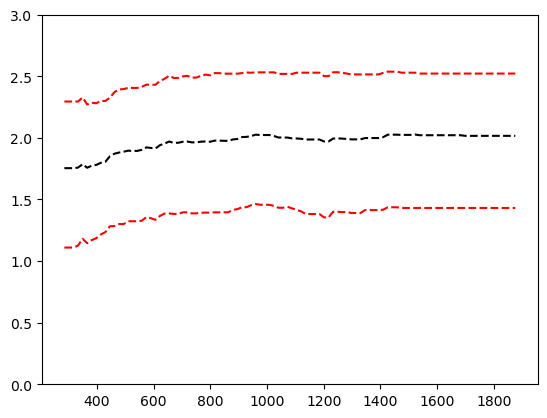

In [222]:
fix, ax = plt.subplots()
ax.plot(pd_bm['grid_values'][0], pd_bm['average'].squeeze(), linestyle='dashed', color='black')
ax.plot(pd_bm['grid_values'][0], np.percentile(pd_bm['individual'], 75, axis=1).squeeze(), linestyle='dashed', color='red')
ax.plot(pd_bm['grid_values'][0], np.percentile(pd_bm['individual'], 25, axis=1).squeeze(), linestyle='dashed', color='red')
ax.set_ylim(0.0, 3.0)

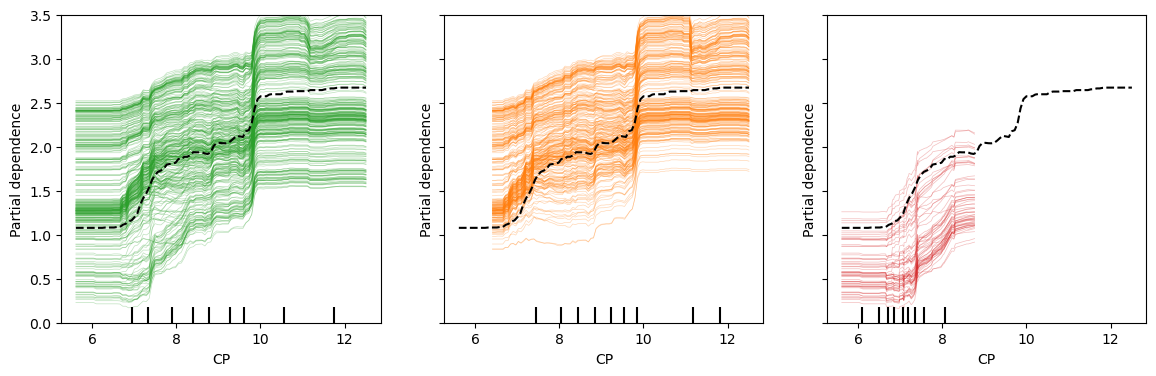

In [374]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 4), sharey='all', sharex='all')
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[df_wts_all_mean['Biomass_kg_ha'] > 400][feature_names],
                                        [0], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:green'},
                                        ax=[axs[0]],
                                        n_jobs=-1)
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[(df_wts_all_mean['Biomass_kg_ha'] > 400) &
                                        (df_wts_all_mean['on_wt'] < 850)][feature_names],
                                        [0], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:orange'},
                                        ax=[axs[1]],
                                        n_jobs=-1)
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[(df_wts_all_mean['Biomass_kg_ha'] > 400) &
                                        (df_wts_all_mean['on_wt'] > 850)][feature_names],
                                        [0], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:red'},
                                        ax=[axs[2]],
                                        n_jobs=-1)

for ax in axs.flatten():
    ax.plot(pd_cp['grid_values'][0], pd_cp['average'].squeeze(), linestyle='dashed', color='black')
    ax.set_ylim(0.0, 3.5)

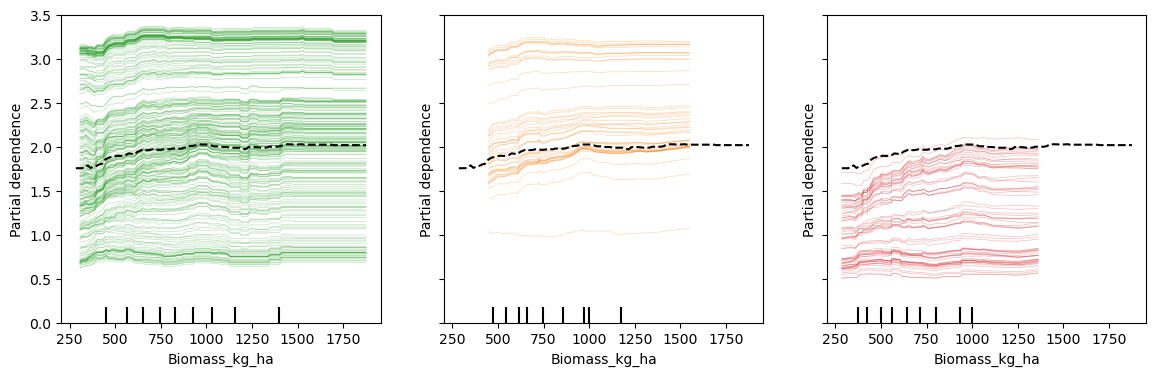

In [225]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 4), sharey='all', sharex='all')
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[df_wts_all_mean['on_au_ha'] < 0.15][feature_names],
                                        [2], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:green'},
                                        ax=[axs[0]],
                                        n_jobs=-1)
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[(df_wts_all_mean['DOM'] > 63) &
                                        (df_wts_all_mean['on_au_ha'] >= 0.15)][feature_names],
                                        [2], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:orange'},
                                        ax=[axs[1]],
                                        n_jobs=-1)
PartialDependenceDisplay.from_estimator(rf_adg_fnl,
                                        df_wts_all_mean[(df_wts_all_mean['DOM'] <= 63) &
                                        (df_wts_all_mean['on_au_ha'] >= 0.15)][feature_names],
                                        [2], 
                                        kind='individual',
                                        percentiles=(0.0, 1.0),
                                        ice_lines_kw={'color': 'tab:red'},
                                        ax=[axs[2]],
                                        n_jobs=-1)

for ax in axs.flatten():
    ax.plot(pd_bm['grid_values'][0], pd_bm['average'].squeeze(), linestyle='dashed', color='black')
    ax.set_ylim(0.0, 3.5)

In [355]:
df_wts_all_mean['DOM:CP'] = df_wts_all_mean['DOM']/df_wts_all_mean['CP']

<AxesSubplot:xlabel='DOM:CP', ylabel='adg'>

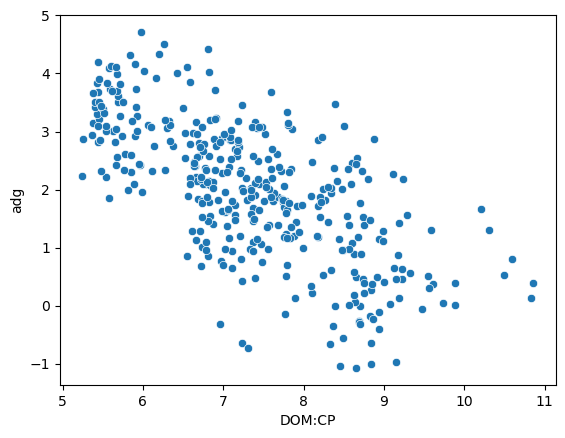

In [356]:
sns.scatterplot(x='DOM:CP', y='adg', data=df_wts_all_mean)

In [364]:
ice_dom_lo = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['DOM'] <= 62) &
(df_wts_all_mean['on_au_ha'] >= 0.15)].index.values]
ice_dom_med = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['DOM'] > 62) &
(df_wts_all_mean['DOM'] < 64) &
(df_wts_all_mean['on_au_ha'] >= 0.15)].index.values]
ice_dom_hi = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['DOM'] >= 64) &
(df_wts_all_mean['on_au_ha'] >= 0.15)].index.values]

ice_cp_lo = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] <= 7.5)].index.values]
ice_cp_med = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] > 7.5) &
(df_wts_all_mean['CP'] < 9)].index.values]
ice_cp_hi = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] >= 9)].index.values]

ice_cp_lo_wt_hi = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] <= 7.5) &
(df_wts_all_mean['on_wt'] > 850)].index.values]
ice_cp_med_wt_hi = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] > 7.5) &
(df_wts_all_mean['CP'] < 9) &
(df_wts_all_mean['on_wt'] > 850)].index.values]
ice_cp_hi_wt_hi = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] > 9) &
(df_wts_all_mean['on_wt'] > 850)].index.values]

ice_cp_lo_wt_lo = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] < 7.5) &
(df_wts_all_mean['on_wt'] <= 850)].index.values]
ice_cp_med_wt_lo = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] >= 7.5) &
(df_wts_all_mean['CP'] <= 9) &
(df_wts_all_mean['on_wt'] <= 850)].index.values]
ice_cp_hi_wt_lo = pd_bm['individual'].squeeze()[df_wts_all_mean[(df_wts_all_mean['CP'] > 9) &
(df_wts_all_mean['on_wt'] <= 850)].index.values]

In [365]:
plot_ices = [ice_cp_hi_wt_lo, ice_cp_med_wt_lo, ice_cp_lo_wt_lo,
            ice_cp_hi_wt_hi, ice_cp_med_wt_hi, ice_cp_lo_wt_hi]
plot_cols = ['tab:green', 'tab:orange', 'tab:red', 
             'tab:green', 'tab:orange', 'tab:red']
plot_titles = ['CP High (> 9.0)', 'CP Mod (7.5 - 9.0)', 'CP Low (< 7.5)',
               '', '', '']

Text(0, 0.5, 'ADG')

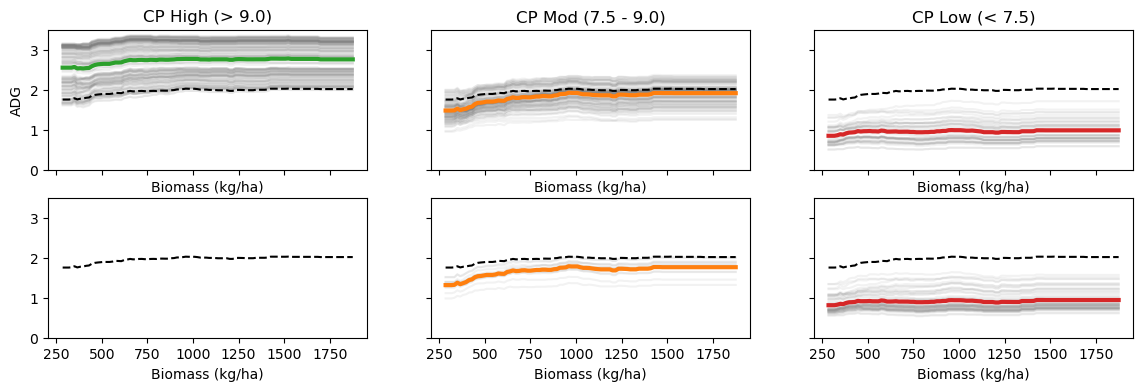

In [371]:
fig, axs = plt.subplots(ncols=len(plot_ices)//2, nrows=len(plot_ices)//3, figsize=(14, 4), sharey='all', sharex='all')
for idx in range(len(plot_ices)):
    for i in range(plot_ices[idx].shape[0]):
        axs.flatten()[idx].plot(pd_bm['grid_values'][0],
                 plot_ices[idx][i, :], color='grey', alpha=0.1)
    axs.flatten()[idx].plot(pd_bm['grid_values'][0],
                 np.mean(plot_ices[idx], axis=0), color=plot_cols[idx], linewidth=3, linestyle='solid')
    axs.flatten()[idx].plot(pd_bm['grid_values'][0], pd_bm['average'].squeeze(), linestyle='dashed', color='black')
    #ax.plot(pd_bm['grid_values'][0], plot_ices[idx], color=plot_cols[idx], alpha=0.6)
    axs.flatten()[idx].set_ylim(0.0, 3.5)
    axs.flatten()[idx].set_title(plot_titles[idx])
    axs.flatten()[idx].set_xlabel('Biomass (kg/ha)')
axs.flatten()[0].set_ylabel('ADG')

In [307]:
df_wts_all_mean['Year_str'] = df_wts_all_mean['Year'].astype(str)

In [311]:
df_wts_all_mean[df_wts_all_mean['adg'] < 0]

index  Year PastureID     on_date    off_date   Unnamed: 0    on_wt_raw  \
51      51  2004       23E  2004-09-09  2004-10-14  1099.000000   886.280000   
145    145  2011       15E  2011-09-01  2011-09-30  3126.500000   866.888889   
160    175  2014       15E  2014-09-04  2014-10-03  3759.500000   981.100000   
165    180  2014       23E  2014-09-04  2014-10-03  3884.500000   987.200000   
170    185  2014       23W  2014-09-04  2014-10-03  3997.000000   996.933333   
180    195  2015       23E  2015-09-03  2015-10-03  4214.500000   966.400000   
190    205  2016       15E  2016-08-30  2016-10-01  4419.500000   961.818182   
195    210  2016       23E  2016-08-30  2016-10-01  4549.500000   918.066667   
200    215  2016       23W  2016-08-30  2016-10-01  4662.000000   978.400000   
228    243  2018       23E  2018-08-31  2018-09-29  5307.000000   877.571429   
243    258  2019       19N  2019-09-05  2019-09-27  5960.000000  1023.619048   
249    264  2019       23E  2019-09-05  2019-09-27  5682.500000   961.735294   
254    269  2019       23W  2019-09-05  2019-09-27  5808.705882   986.352941   
277    292  2020       23E  2020-09-03  2020-10-05   342.842105   798.526316   
278    293  2020       23E  2020-09-03  2020-10-06   293.545455   790.727273   
292    307  2021       15E  2021-09-09  2021-10-04   546.250000   974.666667   
299    314  2021       19N  2021-09-09  2021-10-04   637.500000  1049.888889   
306    321  2021       23E  2021-09-09  2021-10-04   755.000000   969.931034   
312    327  2021       23W  2021-09-09  2021-10-04   865.000000   996.933333   
317    332  2022       15E  2022-07-14  2022-08-01   923.357143   795.428571   
321    336  2022       19N  2022-07-14  2022-08-01   974.000000   852.631579   
329    344  2022       23W  2022-07-14  2022-08-01  1095.000000   848.705882   

      off_wt_raw       on_wt      off_wt  ...  on_ct_ha      on_au  on_au_ha  \
51    886.240000  886.280000  886.240000  ...  0.208733  22.157000  0.184996   
145   866.555556  866.888889  866.555556  ...  0.151217  17.337778  0.131089   
160   969.300000  910.850000  901.000000  ...  0.151217  18.217000  0.137736   
165   953.933333  916.600000  886.633333  ...  0.250480  27.498000  0.229590   
170   975.466667  925.666667  906.533333  ...  0.118596  13.885000  0.109780   
180   959.600000  897.300000  892.000000  ...  0.250480  26.919000  0.224756   
190   938.454545  892.909091  872.272727  ...  0.166339  19.644000  0.148526   
195   913.333333  852.366667  848.933333  ...  0.250480  25.571000  0.213501   
200   943.866667  908.400000  877.400000  ...  0.118596  13.626000  0.107732   
228   869.771429  814.714286  808.371429  ...  0.292227  28.515000  0.238081   
243   998.761905  950.942095  928.848571  ...  0.205761  24.724494  0.195667   
249   935.235294  892.911765  869.382353  ...  0.283877  30.359000  0.253477   
254   984.117647  915.941176  914.764706  ...  0.134409  15.571000  0.123110   
277   788.631579  741.830947  733.427368  ...  0.283877  25.222252  0.210589   
278   780.181818  734.585636  725.569091  ...  0.283877  24.975912  0.208532   
292   970.000000  905.465333  902.100000  ...  0.151217  18.109307  0.136922   
299  1033.666667  975.346778  961.310000  ...  0.189934  23.408323  0.185251   
306   960.689655  901.065931  893.441379  ...  0.250480  27.031978  0.225699   
312   985.333333  926.151067  916.360000  ...  0.118596  13.892266  0.109838   
317   791.714286  726.226286  720.460000  ...  0.173900  16.703205  0.126291   
321   842.736842  778.452632  766.890526  ...  0.213675  21.018221  0.166336   
329   837.058824  774.868471  761.723529  ...  0.134409  13.172764  0.104149   

           CP        DOM  Biomass_kg_ha  forage_kg_au  period    DOM:CP  \
51   7.316709  61.416991     512.574195    692.681899       4  8.394073   
145  6.853608  59.616315     562.503428   1072.754310       4  8.698530   
160  7.378204  61.694530    1050.438457   1906.611823       4  8.361727   
165  7.267500  61.46354

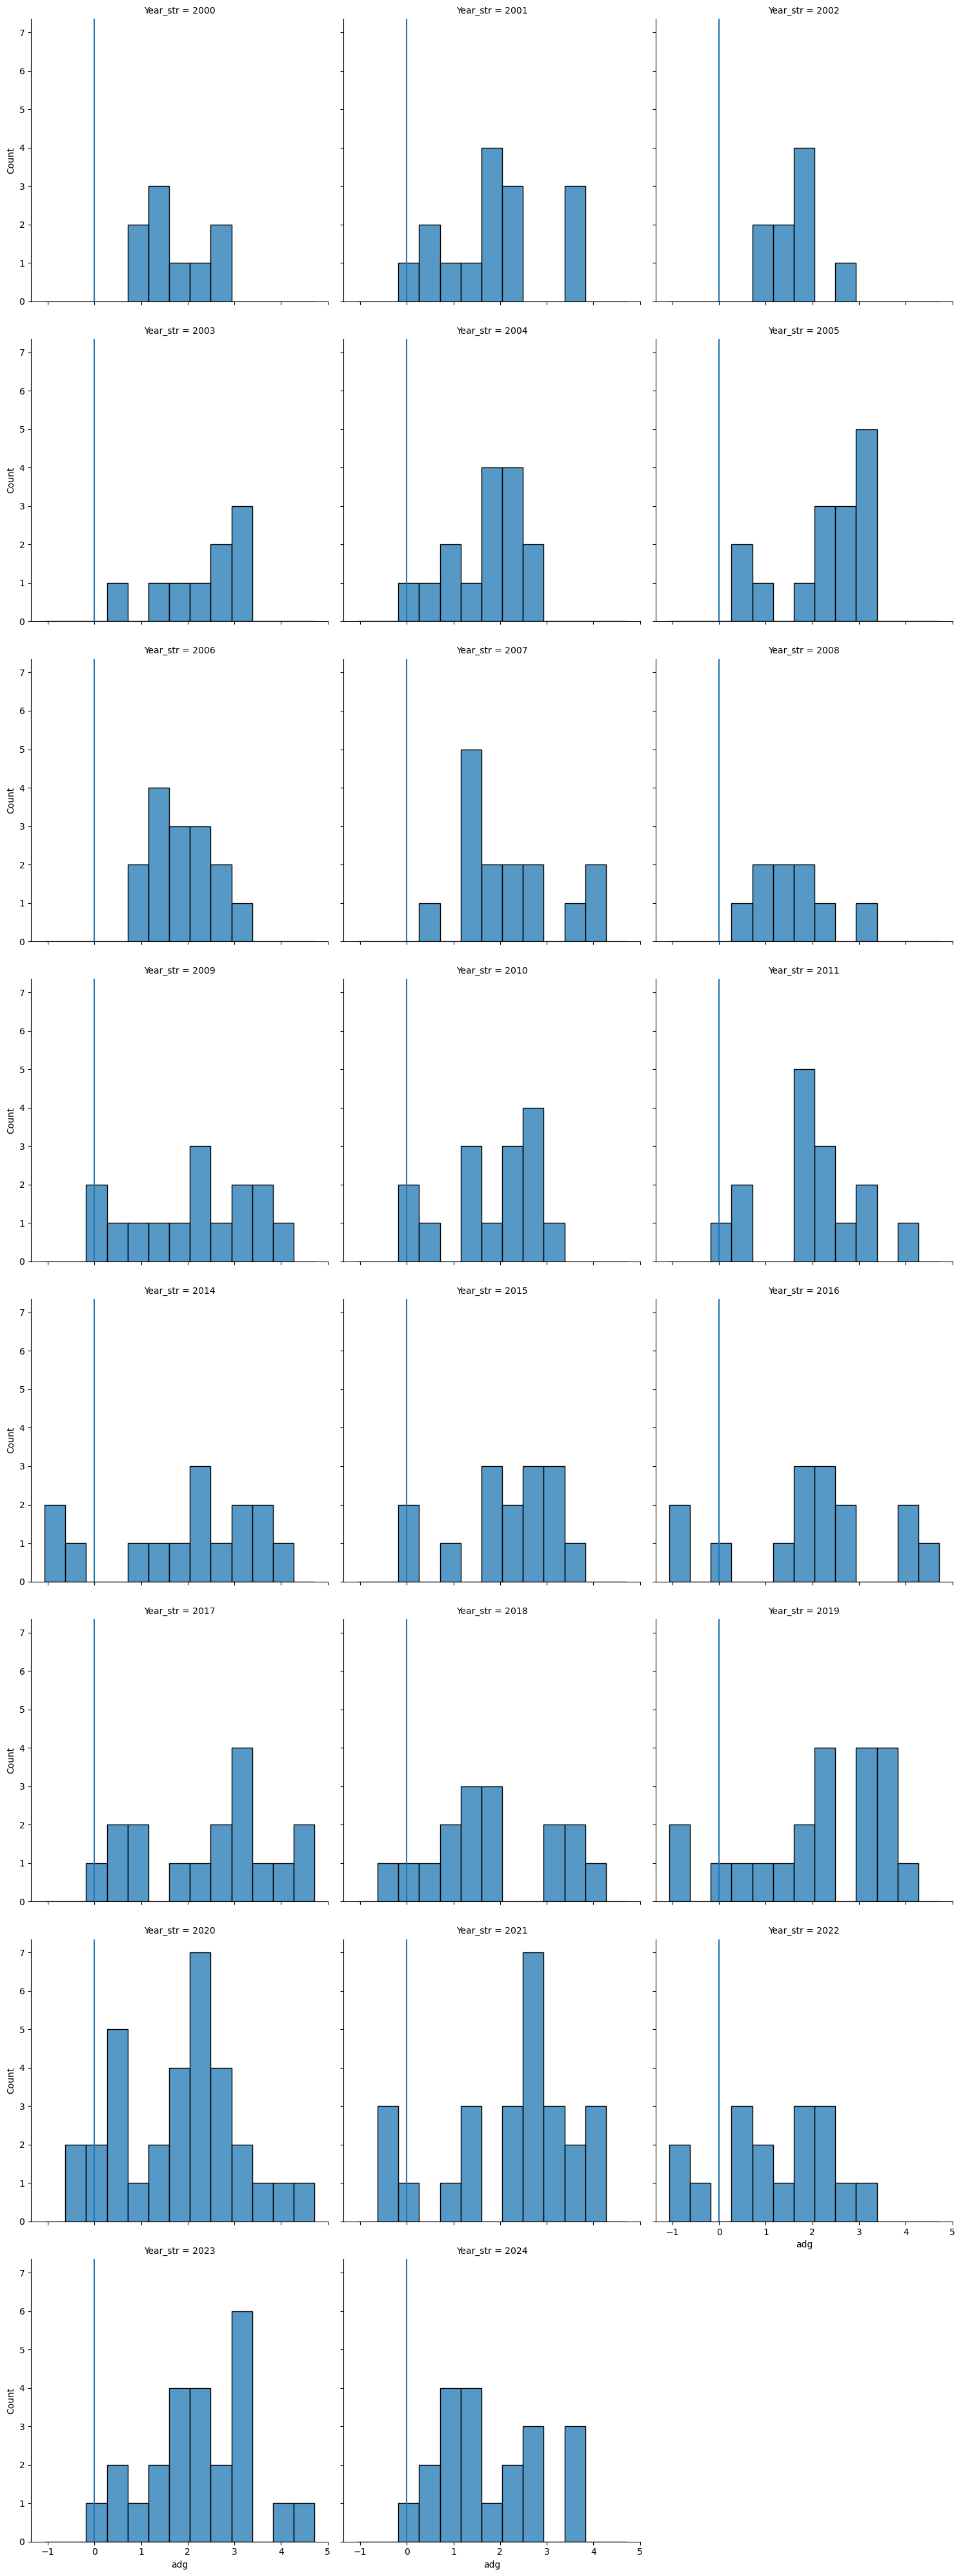

In [310]:
p = sns.displot(x='adg', data=df_wts_all_mean, col='Year_str', col_wrap=3)
for ax in p.axes.flatten():
    ax.axvline(x=0)

In [239]:
t_diff = t[:, 0] - t[:,-1]

In [249]:
t_diff.shape

(70,)

In [255]:
list(np.where(t_diff.squeeze() < -0.5)[0])

[0, 8, 11, 20, 28, 41, 53, 58, 60, 62]

In [259]:
df_wts_all_mean[(df_wts_all_mean['DOM'] <= 63) &
                                        (df_wts_all_mean['on_au_ha'] >= 0.15)].loc[[16, 17]]

index  Year PastureID     on_date    off_date  Unnamed: 0  on_wt_raw  \
16     16  2001       23E  2001-07-13  2001-08-10       327.0     790.32   
17     17  2001       23E  2001-08-10  2001-09-07       385.0     837.52   

    off_wt_raw   on_wt  off_wt  ...       adg  area_ha  on_ct_ha   on_au  \
16      837.52  790.32  837.52  ...  1.685714   119.77  0.208733  19.758   
17      896.48  837.52  896.48  ...  2.105714   119.77  0.208733  20.938   

    on_au_ha        CP        DOM  Biomass_kg_ha  forage_kg_au  period  
16  0.164966  8.494295  62.602203    1109.393467   1681.243744       2  
17  0.174818  7.183904  61.690368    1038.532886   1485.159564       3  

[2 rows x 21 columns]

In [260]:
df_wts_all_mean[(df_wts_all_mean['DOM'] <= 63) &
                                        (df_wts_all_mean['on_au_ha'] >= 0.15)].iloc[list(np.where(t_diff.squeeze() < -0.5)[0])]

index  Year PastureID     on_date    off_date  Unnamed: 0   on_wt_raw  \
16      16  2001       23E  2001-07-13  2001-08-10       327.0  790.320000   
64      64  2005       23E  2005-07-14  2005-08-11      1277.0  774.000000   
78      78  2006       23E  2006-06-15  2006-07-13      1506.0  698.413793   
133    133  2010       23E  2010-07-15  2010-08-12      2645.5  779.333333   
179    194  2015       23E  2015-08-06  2015-09-03      4213.5  928.866667   
242    257  2019       19N  2019-08-08  2019-09-05      5936.5  936.538462   
298    313  2021       19N  2021-08-12  2021-09-09       631.5  980.700000   
321    336  2022       19N  2022-07-14  2022-08-01       974.0  852.631579   
346    361  2023       23E  2023-08-10  2023-09-07      1370.5  899.769231   
357    372  2024       15E  2024-07-11  2024-08-08      1560.0  786.166667   

      off_wt_raw       on_wt      off_wt  ...       adg  area_ha  on_ct_ha  \
16    837.520000  790.320000  837.520000  ...  1.685714   119.77  0.208733   
64    835.600000  774.000000  835.600000  ...  2.200000   119.77  0.208733   
78    719.379310  698.413793  719.379310  ...  0.748768   119.77  0.250480   
133   838.466667  779.333333  838.466667  ...  2.111905   119.77  0.250480   
179   966.400000  844.800000  897.300000  ...  1.875000   119.77  0.250480   
242  1010.384615  852.250000  938.647308  ...  3.085618   126.36  0.205761   
298  1045.400000  892.437000  971.176600  ...  2.812129   126.36  0.189934   
321   842.736842  778.452632  766.890526  ... -0.642339   126.36  0.213675   
346   973.923077  818.790000  904.774538  ...  3.070876   119.77  0.217083   
357   837.966667  717.770167  762.549667  ...  1.599268   132.26  0.226826   

         on_au  on_au_ha        CP        DOM  Biomass_kg_ha  forage_kg_au  \
16   19.758000  0.164966  8.494295  62.602203    1109.393467   1681.243744   
64   19.350000  0.161560  8.588670  62.577562     759.896454   1175.875948   
78   20.952414  0.174939  8.362793  62.532151     553.443430    790.910301   
133  23.380000  0.195207  8.437289  62.428169    1062.623181   1360.889418   
179  25.344000  0.211606  8.478885  62.243558     954.336732   1127.494776   
242  22.158500  0.175360  8.314139  62.224530     930.796657   1326.979101   
298  21.418488  0.169504  8.620217  61.894668     999.510452   1474.171994   
321  21.018221  0.166336  8.679046  62.778078     430.792721    647.473543   
346  21.288540  0.177745  8.424368  62.776658     950.667607   1337.121513   
357  21.533105  0.162809  8.030588  62.478587     371.518687    570.482769   

     period  
16        2  
64        2  
78        1  
133       2  
179       3  
242       3  
298       4  
321       3  
346       4  
357       3  

[10 rows x 21 columns]

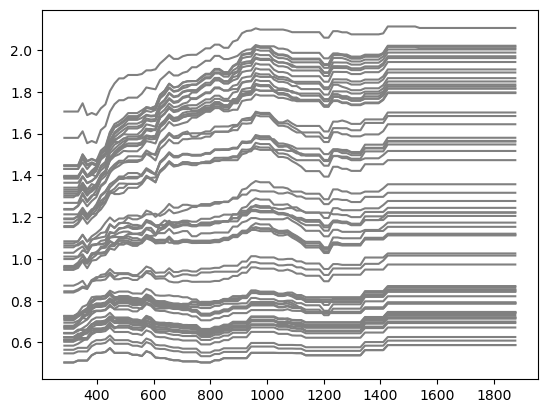

In [237]:
fig, ax = plt.subplots()
for i in range(t.shape[0]):
    plt.plot(pd_bm['grid_values'][0],
             t[i, :], color='grey')

In [231]:
df_wts_all_mean

Year PastureID     on_date    off_date  Unnamed: 0   on_wt_raw  \
0    2000       15E  2000-05-17  2000-06-15         9.5  599.950000   
1    2000       15E  2000-06-15  2000-07-14        69.5  674.900000   
2    2000       15E  2000-07-14  2000-08-11       129.5  706.600000   
3    2000       23E  2000-05-17  2000-06-15        32.0  600.080000   
4    2000       23E  2000-06-15  2000-07-14        92.0  671.760000   
..    ...       ...         ...         ...         ...         ...   
384  2024       23W  2024-05-13  2024-06-13      1868.0  667.250000   
385  2024       23W  2024-05-14  2024-06-13      1914.0  692.857143   
386  2024       23W  2024-06-13  2024-07-11      1883.0  801.391304   
387  2024       23W  2024-07-11  2024-08-08      1884.0  816.956522   
388  2024       23W  2024-08-08  2024-09-09      1885.0  883.086957   

     off_wt_raw       on_wt      off_wt  on_ct       adg  area_ha  on_ct_ha  \
0    674.900000  599.950000  674.900000   20.0  2.584483   132.26  0.151217   
1    706.600000  674.900000  706.600000   20.0  1.093103   132.26  0.151217   
2    746.900000  706.600000  746.900000   20.0  1.439286   132.26  0.151217   
3    671.760000  600.080000  671.760000   25.0  2.471724   119.77  0.208733   
4    699.920000  671.760000  699.920000   25.0  0.971034   119.77  0.208733   
..          ...         ...         ...    ...       ...      ...       ...   
384  804.500000  620.542500  734.508500   23.0  3.676323   126.48  0.181847   
385  794.285714  644.357143  725.182857   23.0  2.694190   126.48  0.181847   
386  816.956522  731.670261  745.881304   23.0  0.507537   126.48  0.181847   
387  883.086957  745.881304  803.609130   23.0  2.061708   126.48  0.181847   
388  908.739130  803.609130  844.218652   23.0  1.269048   126.48  0.181847   

         on_au  on_au_ha        CP        DOM  Biomass_kg_ha  forage_kg_au  \
0    11.999000  0.090723  9.684313  64.832665     936.074278   2579.489625   
1    13.498000  0.102057  8.413528  62.056288     930.282950   2278.841736   
2    14.132000  0.106850  7.123751  59.146467     983.903223   2302.063408   
3    15.002000  0.125257  9.773251  64.916202     989.130433   1974.205972   
4    16.794000  0.140219  8.410041  61.636437     943.416663   1682.044387   
..         ...       ...       ...        ...            ...           ...   
384  14.272478  0.112844  8.554759  64.956763     815.834606   1807.443049   
385  14.820214  0.117174  8.525981  64.905258     813.879720   1736.471299   
386  16.828416  0.133052  8.097610  62.987734     621.501714   1167.779795   
387  17.155270  0.135636  8.042227  62.390561     510.522784    940.977929   
388  18.483010  0.146134  7.982863  63.457863     601.101942   1028.341347   

    period  
0        0  
1        1  
2        2  
3        0  
4        1  
..     ...  
384      0  
385      1  
386      2  
387      3  
388      4  

[374 rows x 20 columns]